# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 9

In [2]:
cluster = '9'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 439
Num noneffect sequences: 439


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
215  chr19   18438073   18438074    rs2303696    NAN       NAN   T    C     C   
387   chr4   89836583   89836584    rs2619361      C         A   C    A     C   
278   chr2   95057163   95057164     rs872580      C         A   C    A     A   
69   chr16   31117346   31117347   rs12716982      C         A   C    A     C   
82   chr17    4908319    4908320    rs7214776      T         C   T    C     T   
410   chr7   23203210   23203211     rs858305      G         C   C    G     C   
277  chr19   45326535   45326536     rs344791      C         G   G    C     C   
120  chr17   45848599   45848600   rs62054817      G         A   G    A     G   
237  chr19   44890258   44890259  rs117310449      T         C   C    T     C   
337   chr3   52712648   52712649  rs150322055      G         C   G  A,C     G   
128  chr17   45852871   45852872   rs79589869      C         A   C    A     C   
222  chr19   44644418   44644419   rs10426401      T         G   T    G     T   
242  chr19   44905578   44905579     rs405509      G         T   T    G     G   
114  chr17   45827030   45827031   rs17689824      T         C   C  G,T     C   
158  chr17   45914521   45914522   rs55682376      G         A   G    A     G   
364   chr4   89709662   89709663     rs356175      T         C   C    T     T   
372   chr4   89829436   89829437    rs2583979      T         A   A    T     T   
405   chr7   23149316   23149317   rs28624974    NAN       NAN   T    C     T   
16   chr10   15532288   15532289   rs11259726      G         C   G  C,T     G   
218  chr19   18508056   18508057    rs4808136      A         G   G    A     G   
392   chr5  102971887  102971888    rs6881225      T         C   T    C     T   
394   chr5  103120549  103120550      rs26523      T         C   C    T     C   
129  chr17   45861027   45861028   rs74872829      G         A   A  C,G     A   
181  chr17   46045881   46045882   rs62063670      T         C   T    C     T   
233  chr19   44845919   44845920   rs77241309      C         G   G    C     G   
191  chr17   46765769   46765770     rs199528      T         C   C    T     C   
257  chr19   44951508   44951509    rs7247551      A         G   G    A     A   
276  chr19   45326123   45326124     rs344792      A         G   G    A     A   
329   chr3   52288193   52288194  rs146664705      G         C   C  A,G     C   
388   chr4   89837895   89837896    rs2619363    NAN       NAN   G  C,T     G   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
229  chr19   44800770   44800771  rs139246905      C         T   T  A,C     T   
179  chr17   46023637   46023638   rs62062297      G         A   A    G     A   
1     chr1  171742011  171742012   rs12119232      C         A   A    C     A   
186  chr17   46101517   46101518   rs62061810      G         A   G  A,C     G   
111  chr17   45775766   45775767   rs62055950      T         C   T    C     T   
126  chr17   45849620   45849621    rs8068916      T         G   T  C,G     T   
84   chr17    4909107    4909108   rs16954243      T         A   A    T     A   
176  chr17   46002672   46002673   rs62064663      T         G   T    G     T   
370   chr4   89766355   89766356    rs3796661      T         C   C    T     C   
119  chr17   45841934   45841935   rs56150806      T         C   T    C     T   
173  chr17   46001615   46001616    rs2435201      T         A   T    A     A   
40   chr12   40105791   40105792  rs139518863      T         C   C    T     C   
240  chr19   44891078   44891079   rs71352238      C         T   T    C     T   
407   chr7   23149380   23149381   rs10270788      T         C   T    C     T   
136  chr17   45894090   45894091   rs76594404      G         C   G  A,C     G   
343   chr3  151383902  151383903   rs10935841      T         C   C    T     C   
305   chr2  127107527  127107528  2_127107528    NAN       NAN   .    .     .   
157  chr17   45914414   45914415   rs1

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 215   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  8.40E-01
Alzheimers_Kunkle_2019 		  1.89E-05
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.821   ||   Center / 200bp : 0.4422
Noneffect Sequence : GGCCGTCCCCGCCCCGAACC


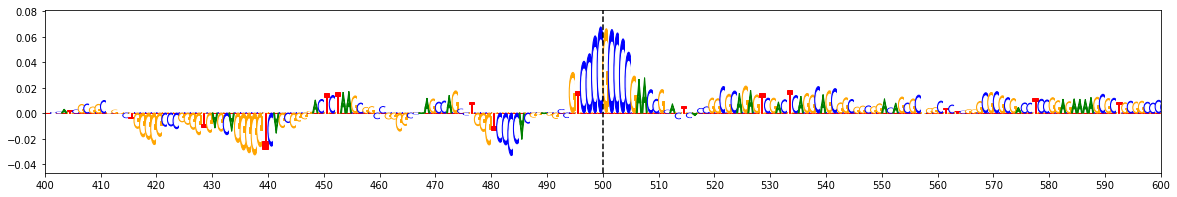

Effect Allele : NAN   ||   Explain Score : 0.2295   ||   Center / 200bp : 0.1808
Effect Sequence : GGCCGTCCCTGCCCCGAACC


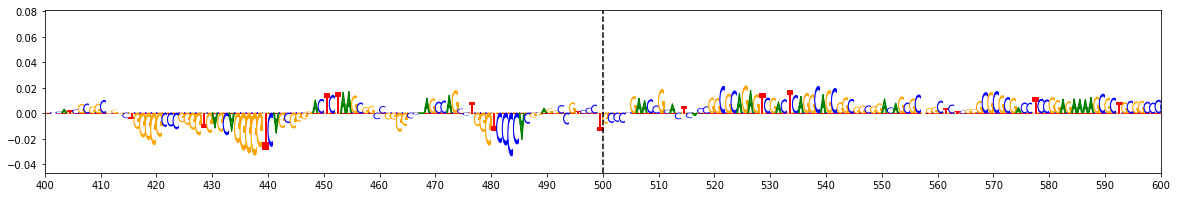

Allele Ratio : 0.2796   ||   Allele Difference : -0.6339  ||  ISM Score : -1.0173  ||  deltaSVM Score : -5.7589


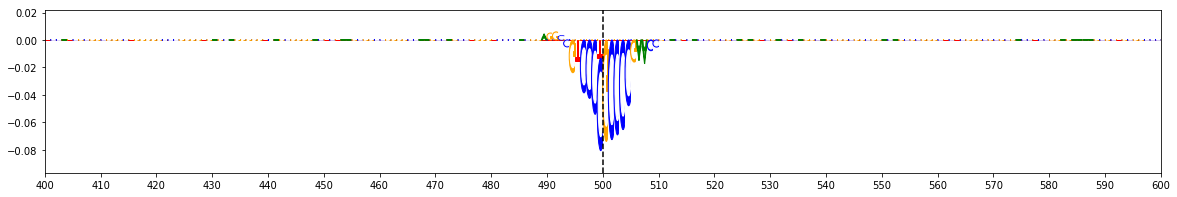


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 387   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6935   ||   Center / 200bp : 0.443
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


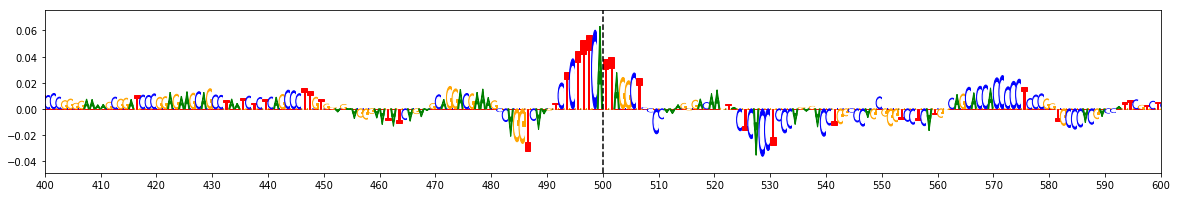

Effect Allele : C   ||   Explain Score : 0.2038   ||   Center / 200bp : 0.1893
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


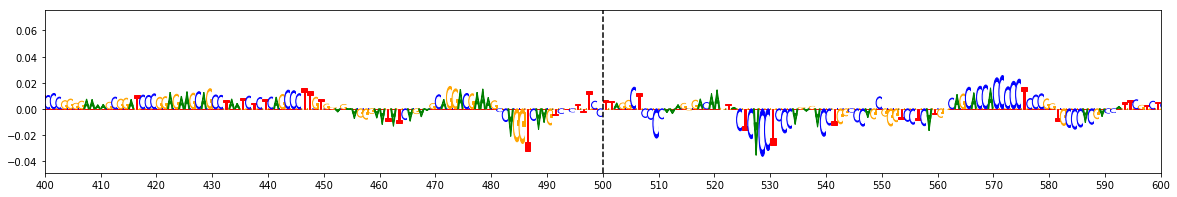

Allele Ratio : 0.2939   ||   Allele Difference : -0.5419  ||  ISM Score : -0.848  ||  deltaSVM Score : -4.9077


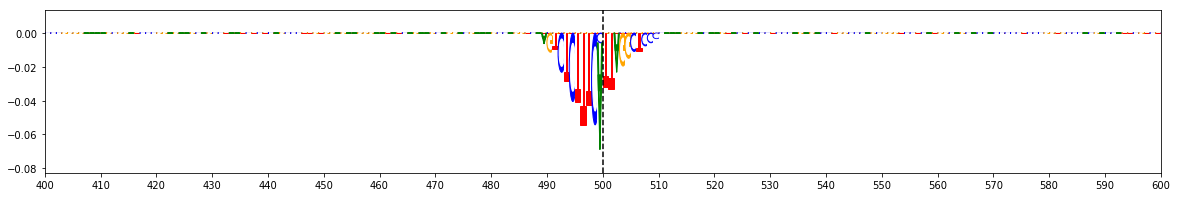


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 278   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.04E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.4405   ||   Center / 200bp : 0.2791
Noneffect Sequence : TTCCATGGCACTCGAGCAGC


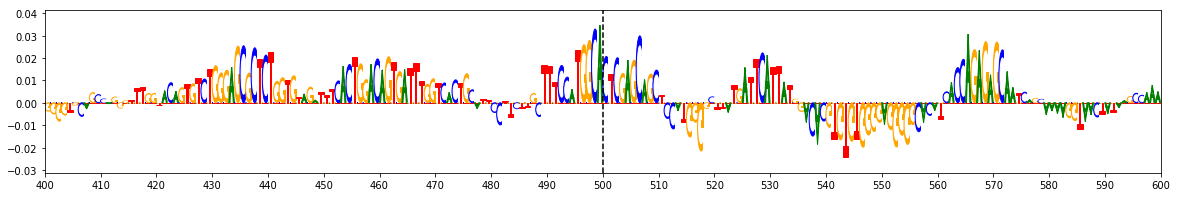

Effect Allele : C   ||   Explain Score : 0.0909   ||   Center / 200bp : 0.074
Effect Sequence : TTCCATGGCCCTCGAGCAGC


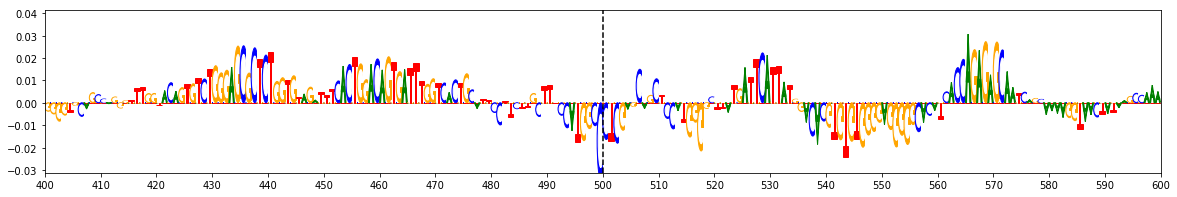

Allele Ratio : 0.2064   ||   Allele Difference : -0.5402  ||  ISM Score : -0.8381  ||  deltaSVM Score : -4.8932


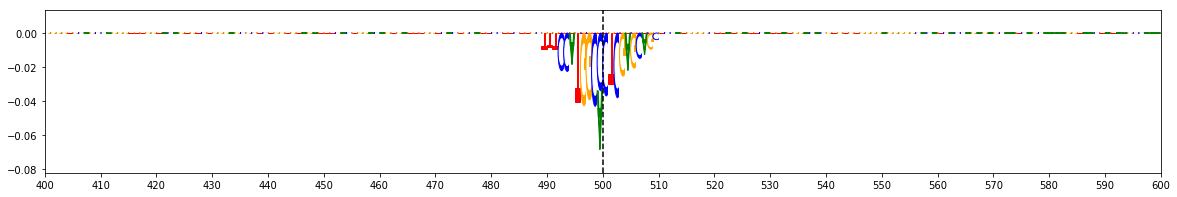


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12716982   ||    chr16 : 31117346 - 31117347   ||    Locus: 69   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.40E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.5754   ||   Center / 200bp : 0.5824
Noneffect Sequence : CAGCCTGGGAGACAGAGCAT


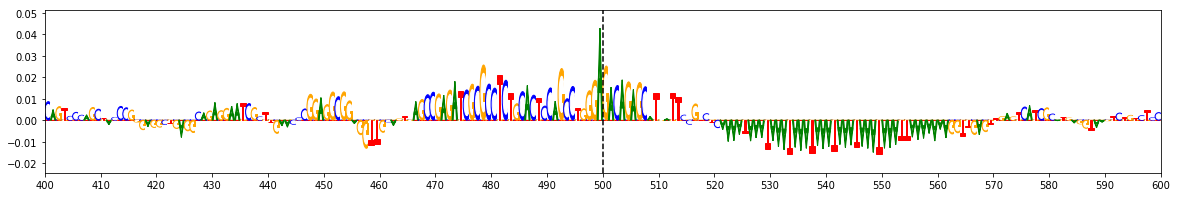

Effect Allele : C   ||   Explain Score : 0.2782   ||   Center / 200bp : 0.4027
Effect Sequence : CAGCCTGGGCGACAGAGCAT


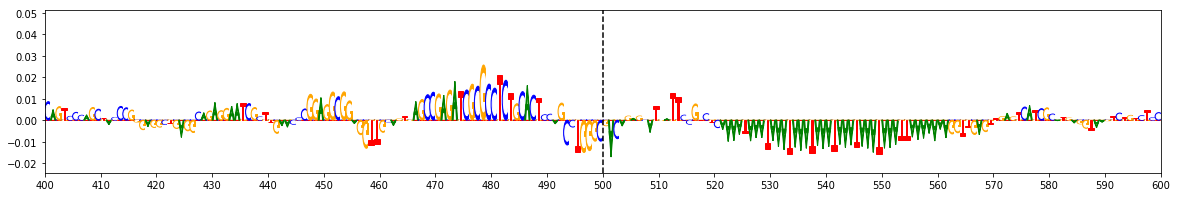

Allele Ratio : 0.4834   ||   Allele Difference : -0.4145  ||  ISM Score : -0.8106  ||  deltaSVM Score : -4.7129


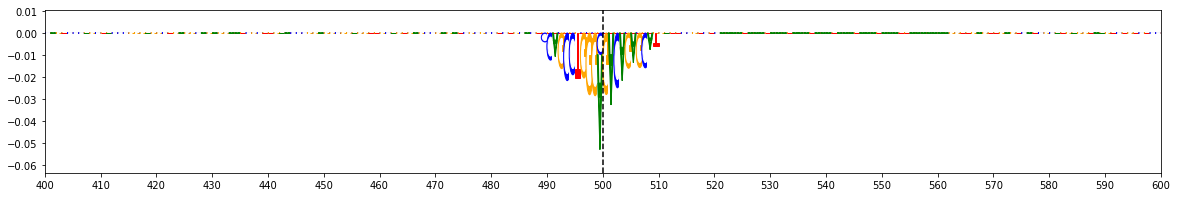


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7214776   ||    chr17 : 4908319 - 4908320   ||    Locus: 82   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  9.21E-04
Alzheimers_Lambert_2013 	  4.27E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.5725   ||   Center / 200bp : 0.5527
Noneffect Sequence : GCATTCACCCGAGAGCCAGG


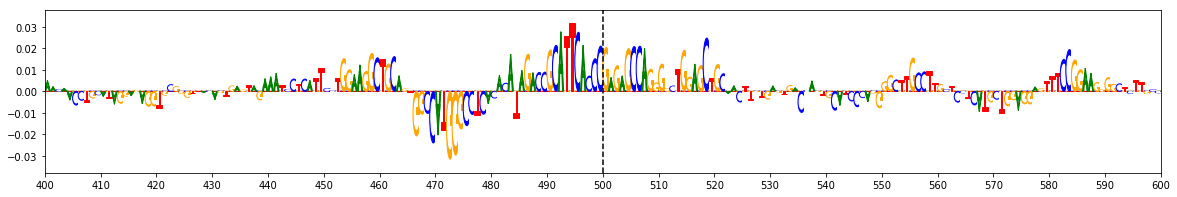

Effect Allele : T   ||   Explain Score : 0.2729   ||   Center / 200bp : 0.3708
Effect Sequence : GCATTCACCTGAGAGCCAGG


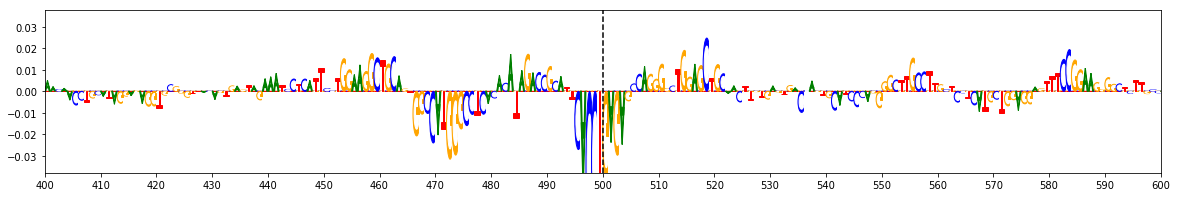

Allele Ratio : 0.4767   ||   Allele Difference : -0.706  ||  ISM Score : -1.1121  ||  deltaSVM Score : -6.3951


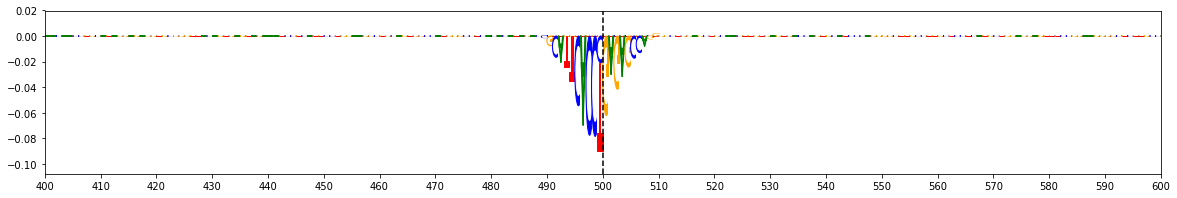


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs858305   ||    chr7 : 23203210 - 23203211   ||    Locus: 410   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  7.39E-06
Nalls_23andMe 		  7.39E-06

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.4449   ||   Center / 200bp : 0.2983
Noneffect Sequence : GGGGCATCGCGGCTTCAGAA


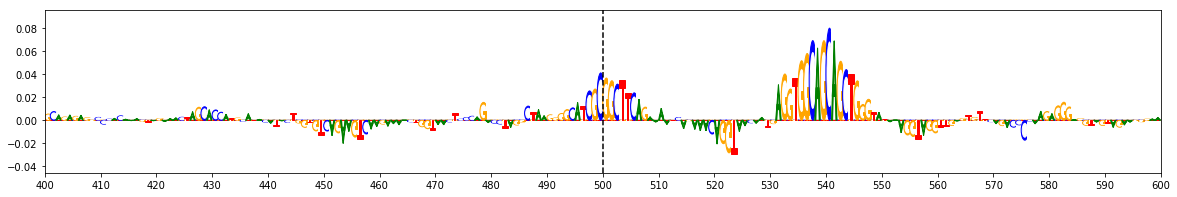

Effect Allele : G   ||   Explain Score : 0.1167   ||   Center / 200bp : 0.1003
Effect Sequence : GGGGCATCGGGGCTTCAGAA


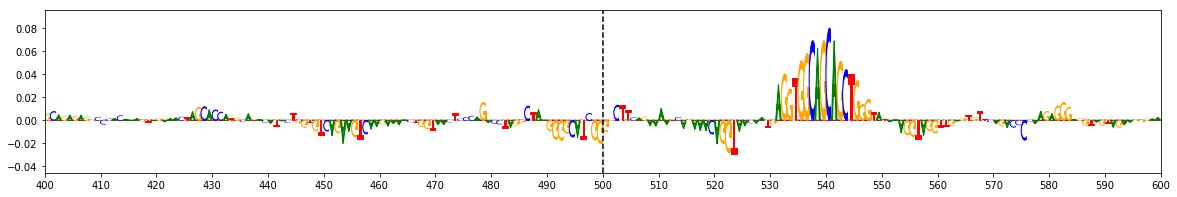

Allele Ratio : 0.2622   ||   Allele Difference : -0.4844  ||  ISM Score : -0.7563  ||  deltaSVM Score : -4.3978


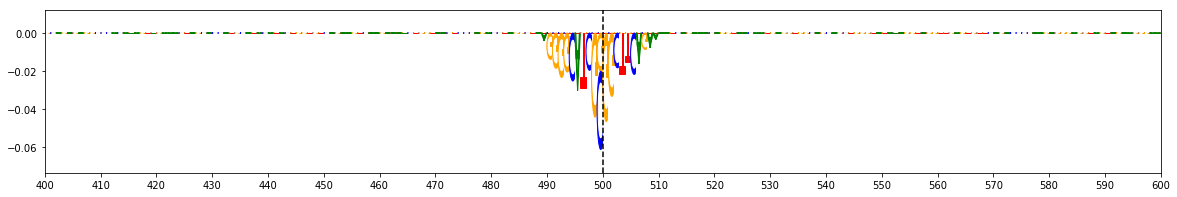


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 277   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.381   ||   Center / 200bp : 0.4785
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


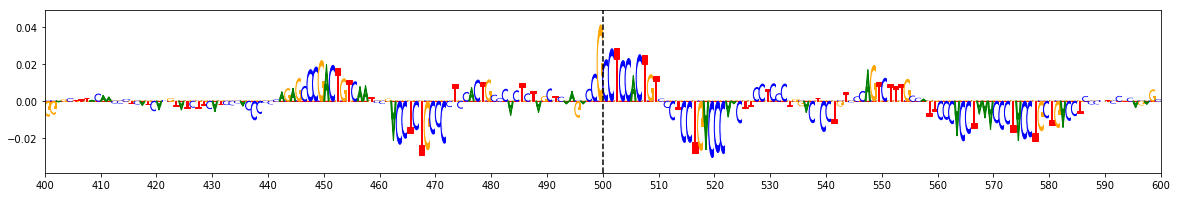

Effect Allele : C   ||   Explain Score : 0.1604   ||   Center / 200bp : 0.2808
Effect Sequence : CTCAAGACCCCCTCCACTGT


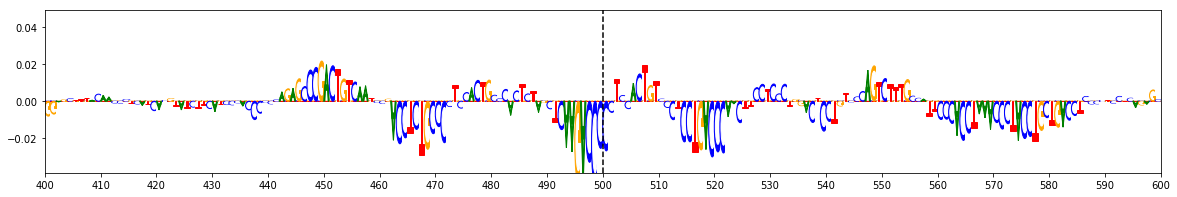

Allele Ratio : 0.4208   ||   Allele Difference : -0.5202  ||  ISM Score : -0.8296  ||  deltaSVM Score : -4.7988


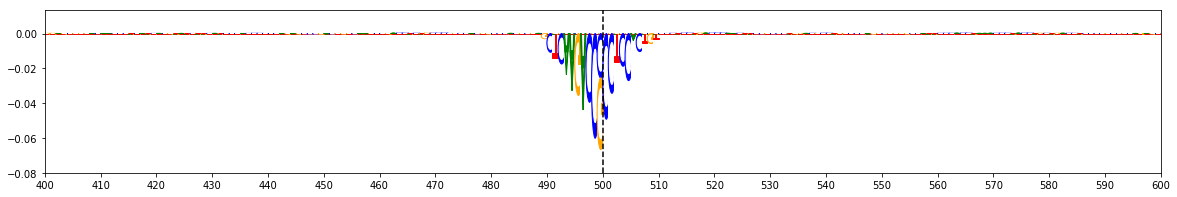


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 120   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.14E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.4746   ||   Center / 200bp : 0.6443
Noneffect Sequence : ATCTTCCCCAGTAGAGGGCC


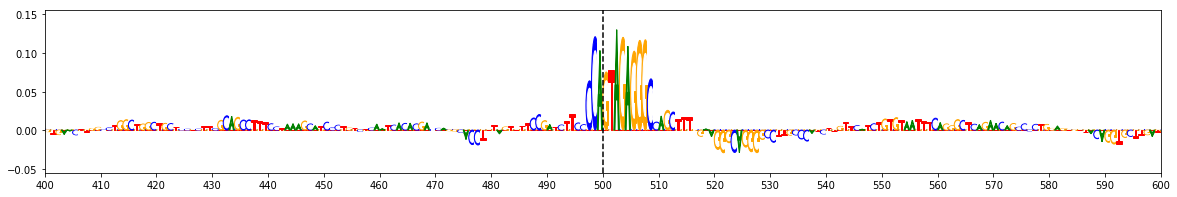

Effect Allele : G   ||   Explain Score : 0.9427   ||   Center / 200bp : 0.5366
Effect Sequence : ATCTTCCCCGGTAGAGGGCC


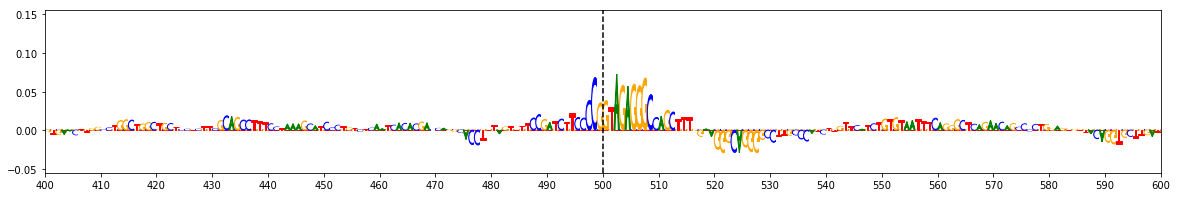

Allele Ratio : 0.6393   ||   Allele Difference : -0.5319  ||  ISM Score : -0.8381  ||  deltaSVM Score : -4.8029


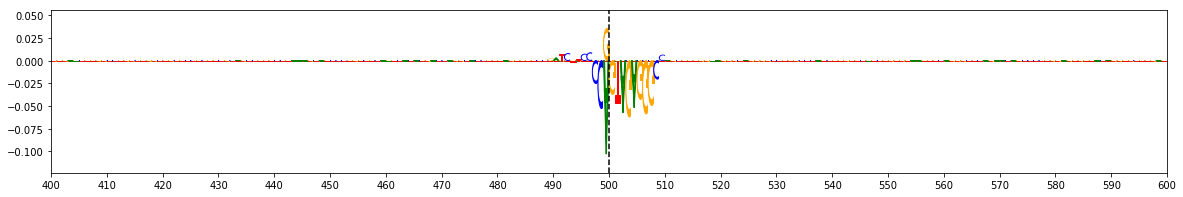


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 237   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.04E-94
Alzheimers_Kunkle_2019 		  2.28E-46
Alzheimers_Lambert_2013 	  3.69E-36

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.9864   ||   Center / 200bp : 0.6808
Noneffect Sequence : GGCCAGAGGCAGAGTGATGA


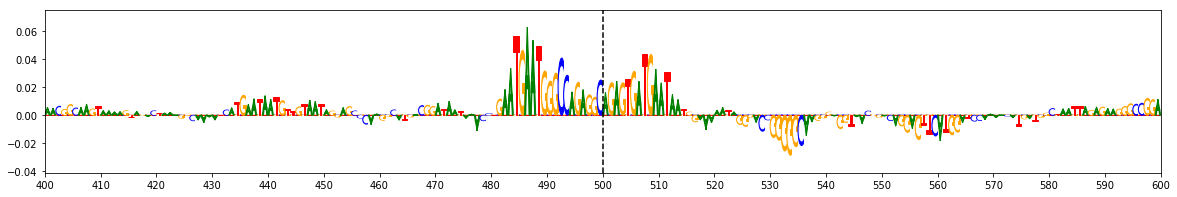

Effect Allele : T   ||   Explain Score : 0.6834   ||   Center / 200bp : 0.5961
Effect Sequence : GGCCAGAGGTAGAGTGATGA


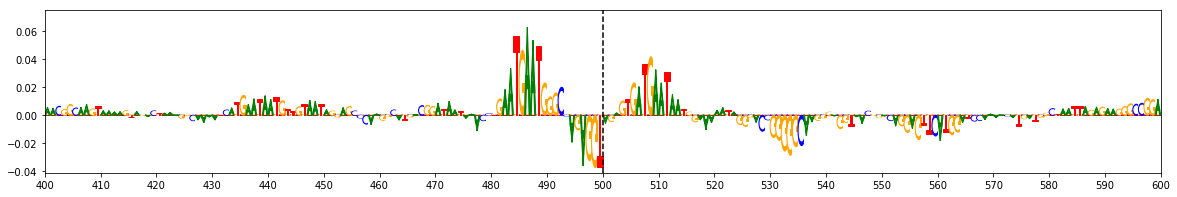

Allele Ratio : 0.6928   ||   Allele Difference : -0.486  ||  ISM Score : -0.7729  ||  deltaSVM Score : -4.4777


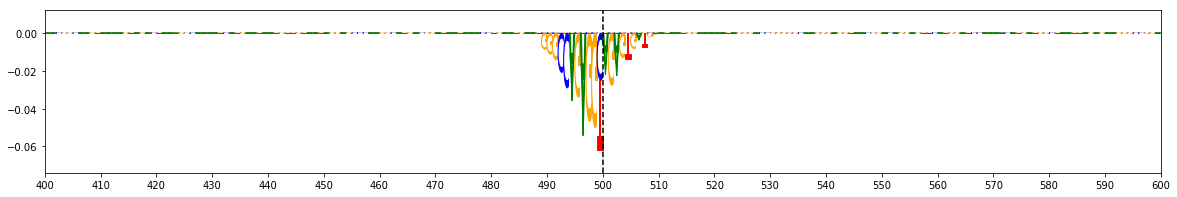


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs150322055   ||    chr3 : 52712648 - 52712649   ||    Locus: 337   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.56E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0967   ||   Center / 200bp : 0.5701
Noneffect Sequence : AGCAGATGCCGGAACCAGAA


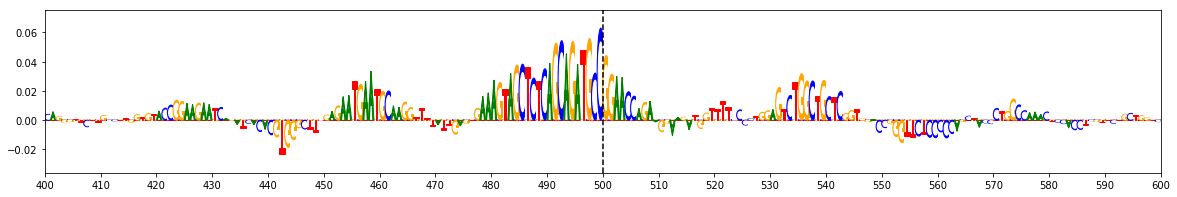

Effect Allele : G   ||   Explain Score : 0.662   ||   Center / 200bp : 0.4445
Effect Sequence : AGCAGATGCGGGAACCAGAA


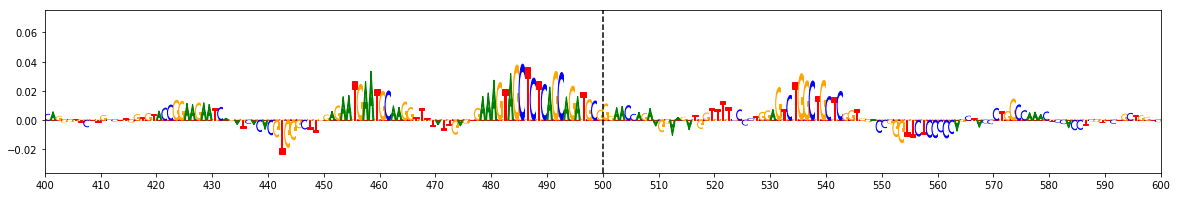

Allele Ratio : 0.6036   ||   Allele Difference : -0.4376  ||  ISM Score : -0.6845  ||  deltaSVM Score : -3.988


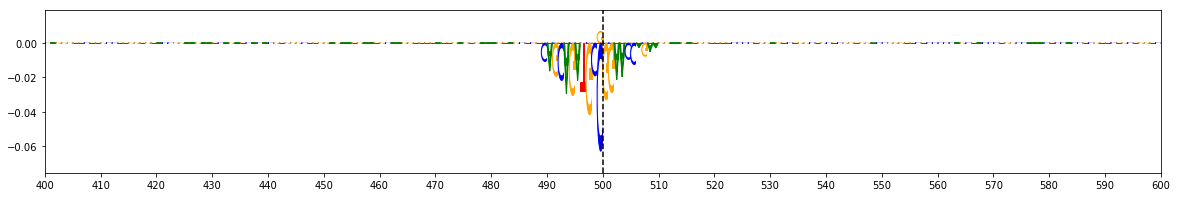


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 128   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 3.1558   ||   Center / 200bp : 0.8406
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


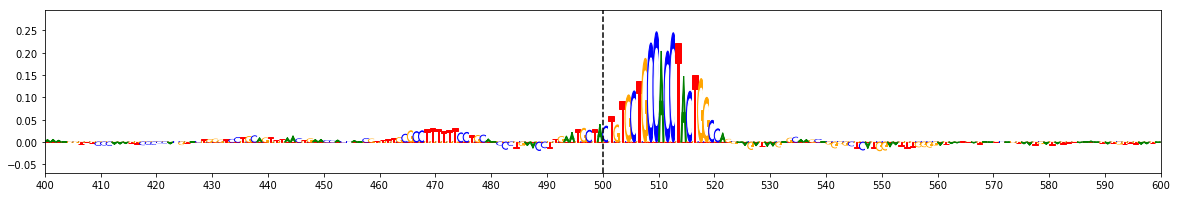

Effect Allele : C   ||   Explain Score : 2.9702   ||   Center / 200bp : 0.8323
Effect Sequence : TTGAATGCTCCTGTGCTGCC


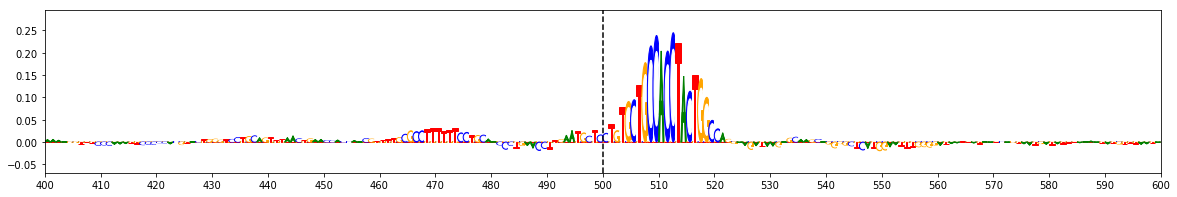

Allele Ratio : 0.9412   ||   Allele Difference : -0.1895  ||  ISM Score : -0.2969  ||  deltaSVM Score : -1.7218


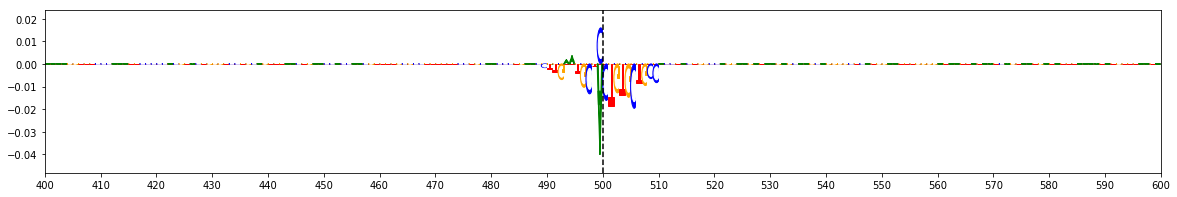


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 222   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0579   ||   Center / 200bp : 0.5438
Noneffect Sequence : CAACACGGGGCGGGCACAAG


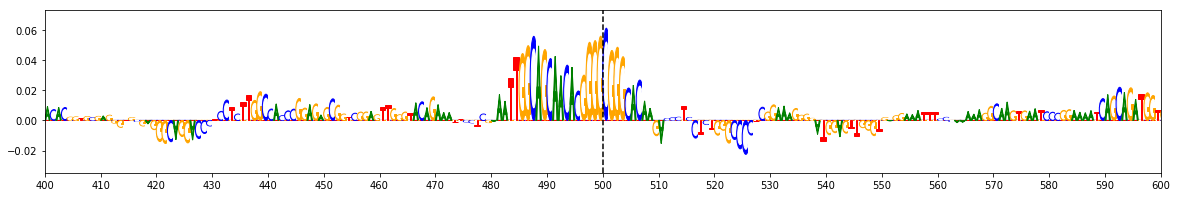

Effect Allele : T   ||   Explain Score : 0.6536   ||   Center / 200bp : 0.4236
Effect Sequence : CAACACGGGTCGGGCACAAG


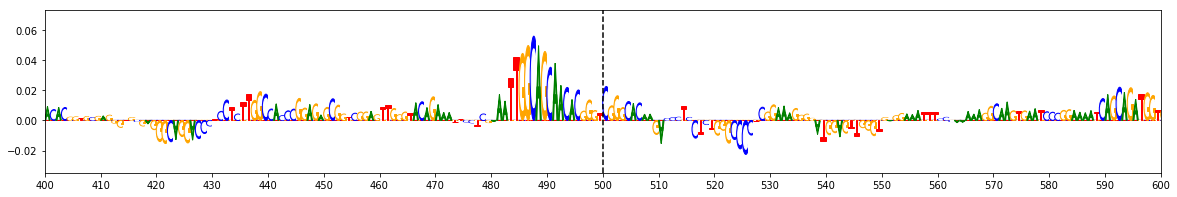

Allele Ratio : 0.6178   ||   Allele Difference : -0.4037  ||  ISM Score : -0.6456  ||  deltaSVM Score : -3.6985


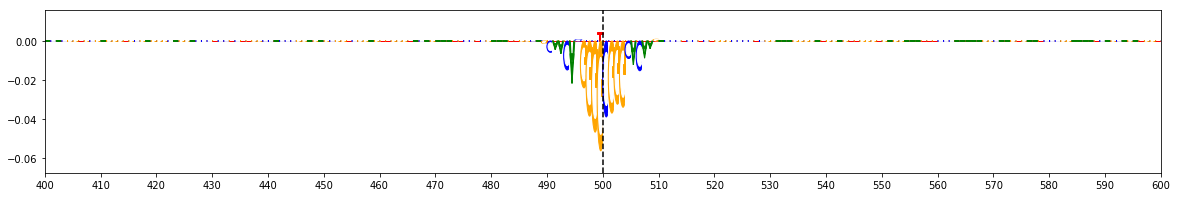


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs405509   ||    chr19 : 44905578 - 44905579   ||    Locus: 242   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.58E-144
Alzheimers_Kunkle_2019 		  3.11E-114
Alzheimers_Lambert_2013 	  4.35E-73

Coloc:  True

Noneffect Allele : T   ||   Explain Score : 0.4046   ||   Center / 200bp : 0.4084
Noneffect Sequence : GGGTGTCTGTATTACTGGGC


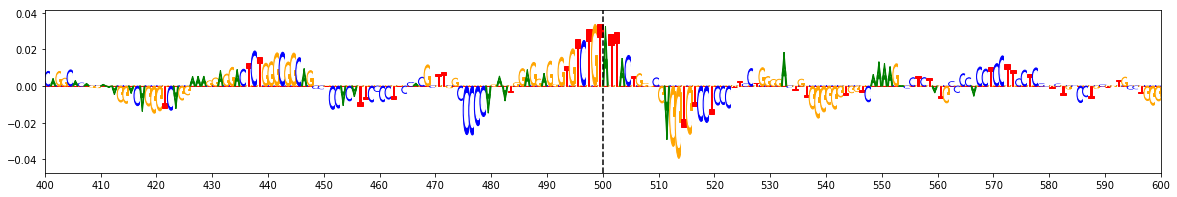

Effect Allele : G   ||   Explain Score : 0.188   ||   Center / 200bp : 0.2431
Effect Sequence : GGGTGTCTGGATTACTGGGC


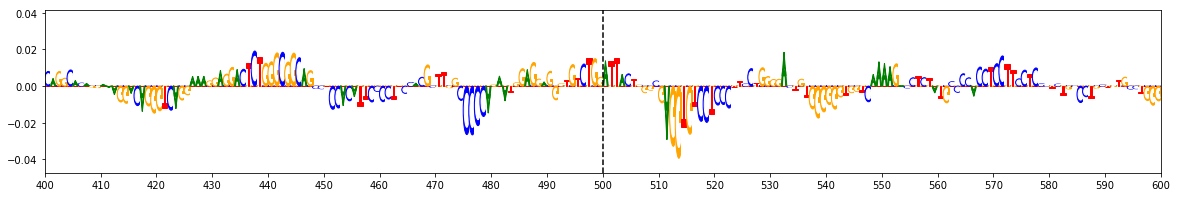

Allele Ratio : 0.4648   ||   Allele Difference : -0.2293  ||  ISM Score : -0.3667  ||  deltaSVM Score : -2.1301


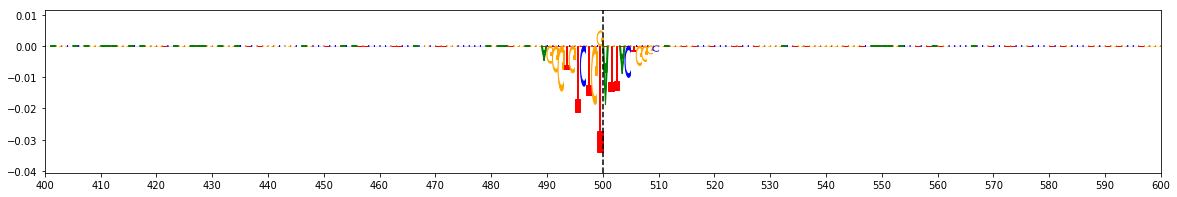


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17689824   ||    chr17 : 45827030 - 45827031   ||    Locus: 114   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.21E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.9022   ||   Center / 200bp : 0.4582
Noneffect Sequence : AAGAGGGAGCTTAAAGCCAG


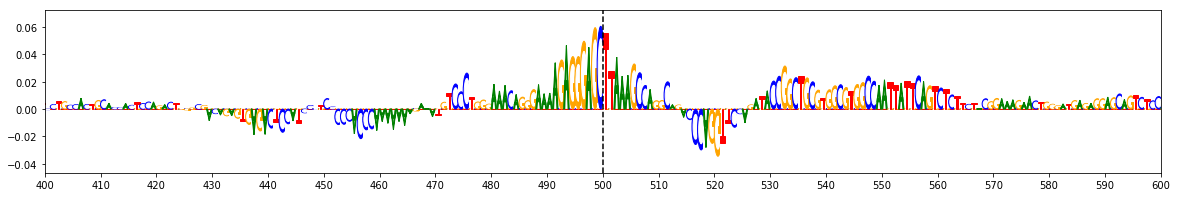

Effect Allele : T   ||   Explain Score : 0.4855   ||   Center / 200bp : 0.3127
Effect Sequence : AAGAGGGAGTTTAAAGCCAG


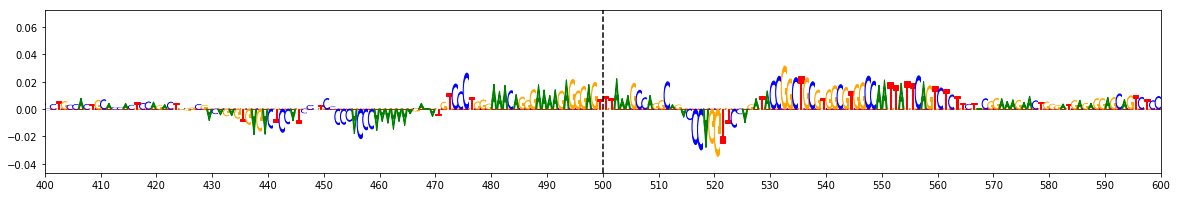

Allele Ratio : 0.5381   ||   Allele Difference : -0.4167  ||  ISM Score : -0.6496  ||  deltaSVM Score : -3.7862


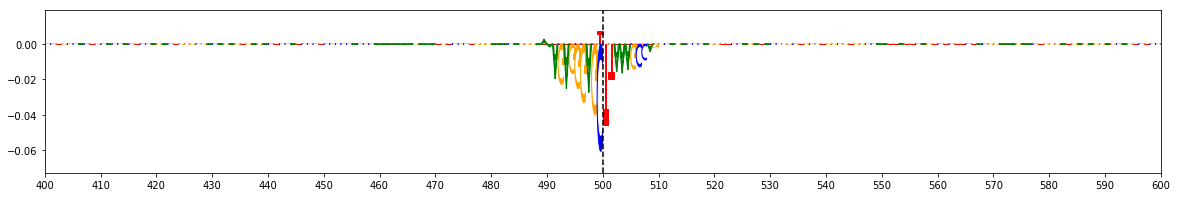


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55682376   ||    chr17 : 45914521 - 45914522   ||    Locus: 158   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.96E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.3059   ||   Center / 200bp : 0.6215
Noneffect Sequence : ACAAGGCAGATACTGTGTAC


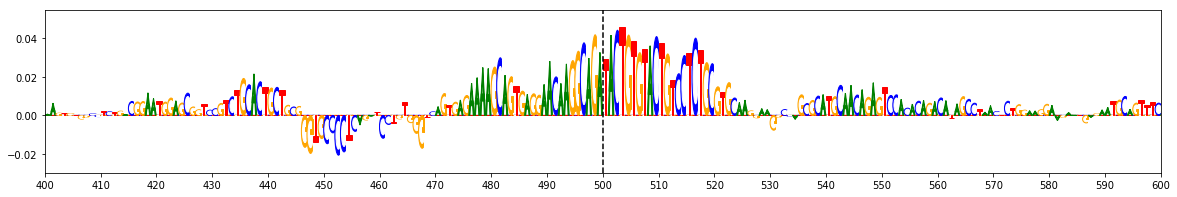

Effect Allele : G   ||   Explain Score : 0.954   ||   Center / 200bp : 0.5447
Effect Sequence : ACAAGGCAGGTACTGTGTAC


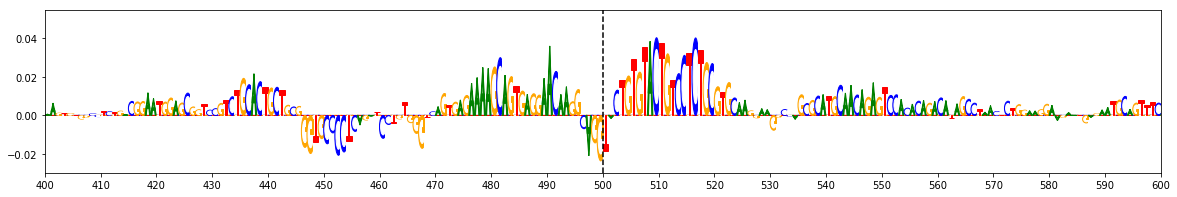

Allele Ratio : 0.7305   ||   Allele Difference : -0.4376  ||  ISM Score : -0.6897  ||  deltaSVM Score : -3.9089


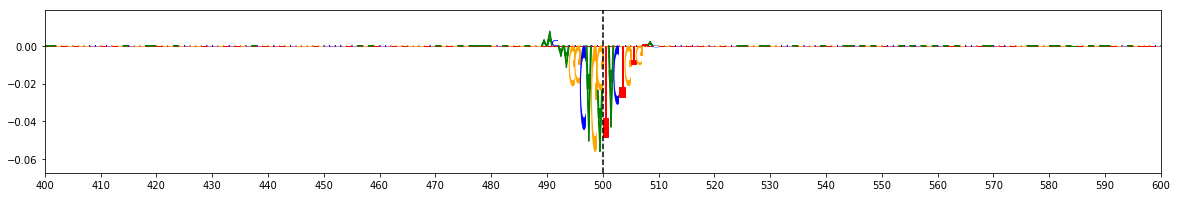


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs356175   ||    chr4 : 89709662 - 89709663   ||    Locus: 364   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.32E-12
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.0512   ||   Center / 200bp : 0.7209
Noneffect Sequence : TCTTTGCTCCCTTGTGTGCC


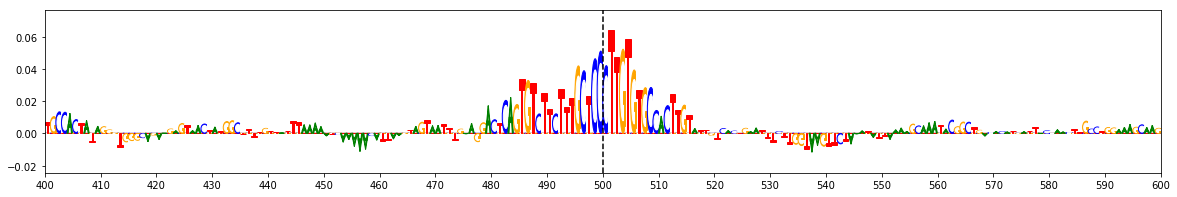

Effect Allele : T   ||   Explain Score : 0.8915   ||   Center / 200bp : 0.6868
Effect Sequence : TCTTTGCTCTCTTGTGTGCC


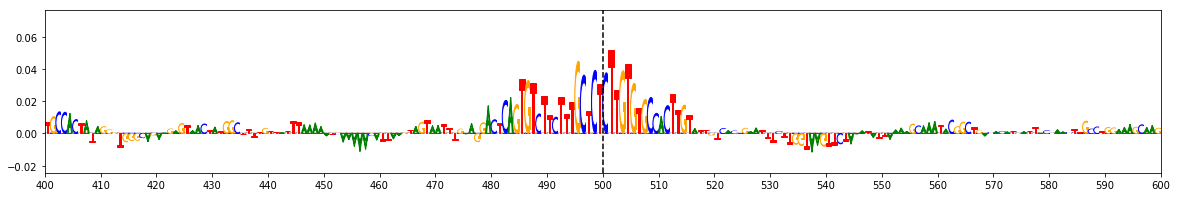

Allele Ratio : 0.8481   ||   Allele Difference : -0.1596  ||  ISM Score : -0.2497  ||  deltaSVM Score : -1.4373


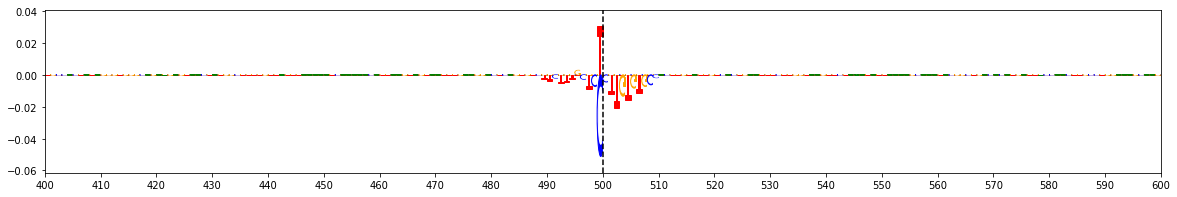


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2583979   ||    chr4 : 89829436 - 89829437   ||    Locus: 372   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  3.63E-14

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.5635   ||   Center / 200bp : 0.5164
Noneffect Sequence : TTTTCAGCAACACTTCCTCT


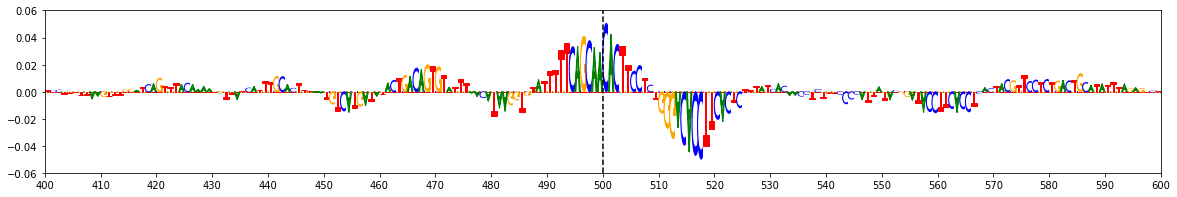

Effect Allele : T   ||   Explain Score : 0.3552   ||   Center / 200bp : 0.4028
Effect Sequence : TTTTCAGCATCACTTCCTCT


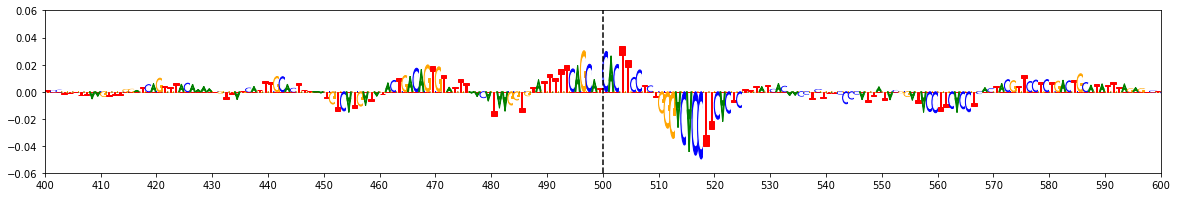

Allele Ratio : 0.6303   ||   Allele Difference : -0.2059  ||  ISM Score : -0.3244  ||  deltaSVM Score : -1.8882


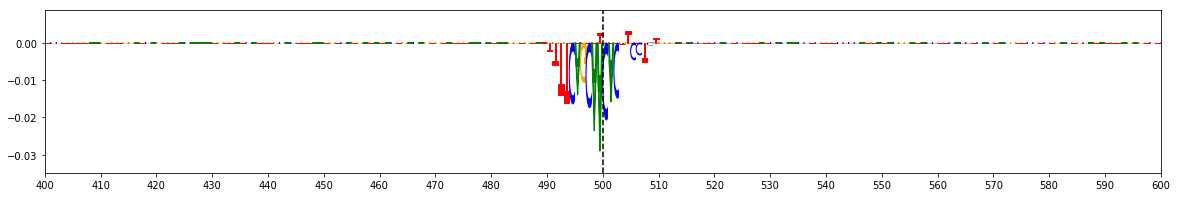


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs28624974   ||    chr7 : 23149316 - 23149317   ||    Locus: 405   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.8342   ||   Center / 200bp : 0.661
Noneffect Sequence : AAGGCCCATTAGTGAAAGAG


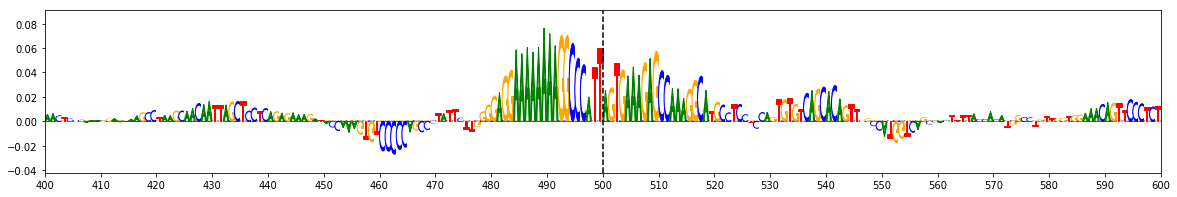

Effect Allele : NAN   ||   Explain Score : 1.4862   ||   Center / 200bp : 0.6129
Effect Sequence : AAGGCCCATCAGTGAAAGAG


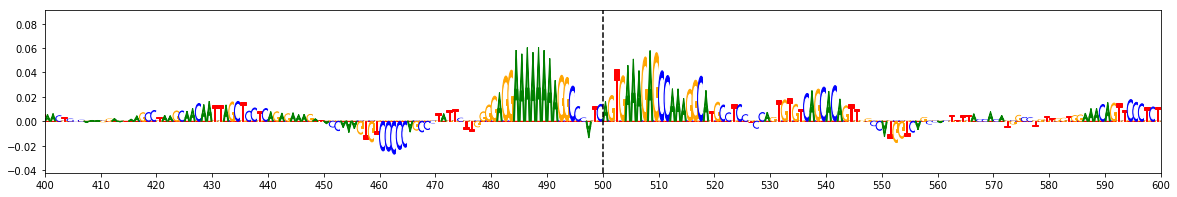

Allele Ratio : 0.8103   ||   Allele Difference : -0.3617  ||  ISM Score : -0.5557  ||  deltaSVM Score : -3.3029


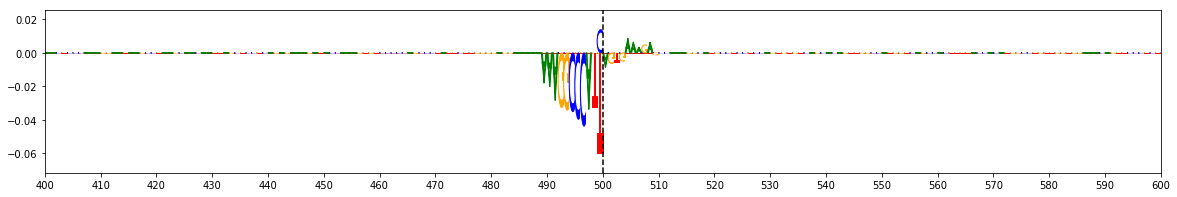


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11259726   ||    chr10 : 15532288 - 15532289   ||    Locus: 16   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.73E-05
Chang_23andMe_Parkinsons 	  6.73E-05

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3089   ||   Center / 200bp : 0.4241
Noneffect Sequence : ATGGTGGCGCGTCCCTATAA


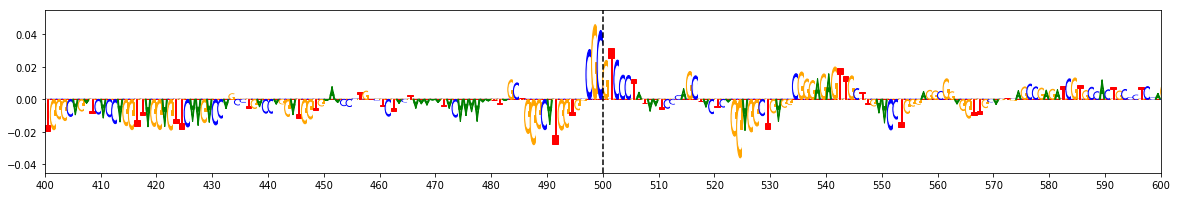

Effect Allele : G   ||   Explain Score : 0.1615   ||   Center / 200bp : 0.278
Effect Sequence : ATGGTGGCGGGTCCCTATAA


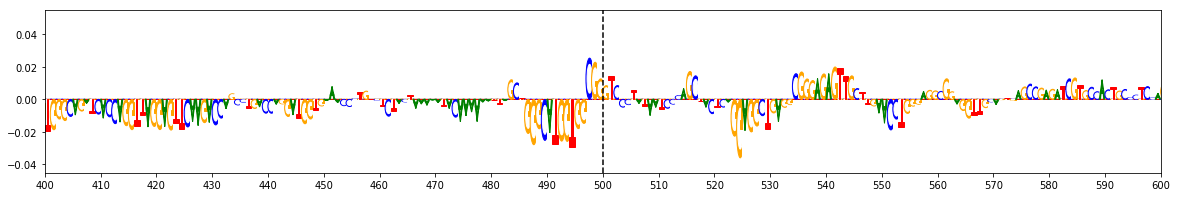

Allele Ratio : 0.5229   ||   Allele Difference : -0.2348  ||  ISM Score : -0.3869  ||  deltaSVM Score : -2.2294


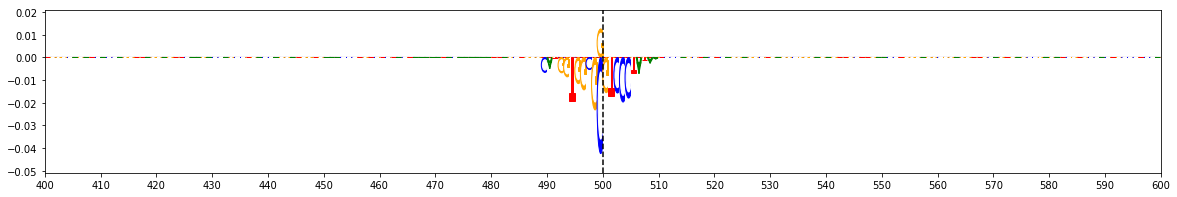


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4808136   ||    chr19 : 18508056 - 18508057   ||    Locus: 218   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.03E-01
Alzheimers_Kunkle_2019 		  6.61E-05
Alzheimers_Lambert_2013 	  6.35E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.3625   ||   Center / 200bp : 0.6269
Noneffect Sequence : CCCACTGGAGGCTATGTCAG


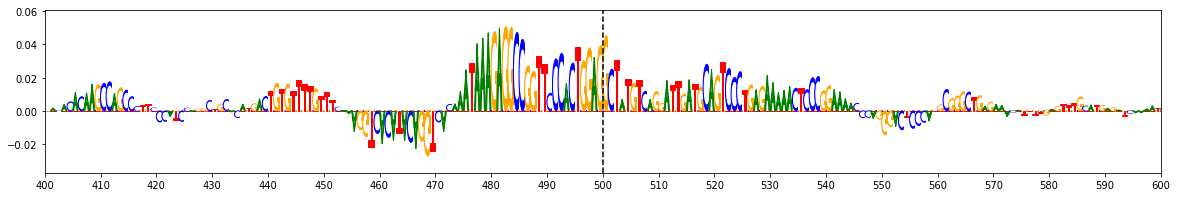

Effect Allele : A   ||   Explain Score : 1.0564   ||   Center / 200bp : 0.5656
Effect Sequence : CCCACTGGAAGCTATGTCAG


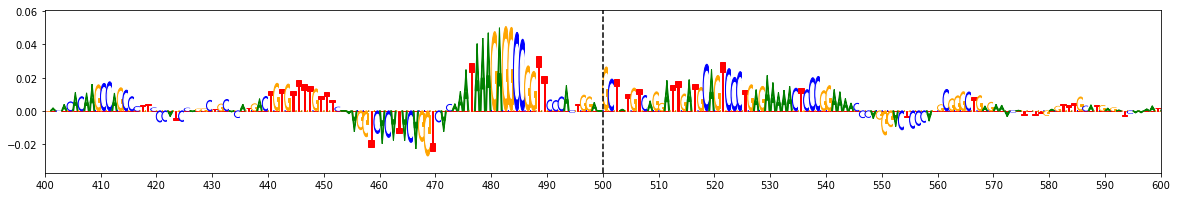

Allele Ratio : 0.7753   ||   Allele Difference : -0.307  ||  ISM Score : -0.4809  ||  deltaSVM Score : -2.8101


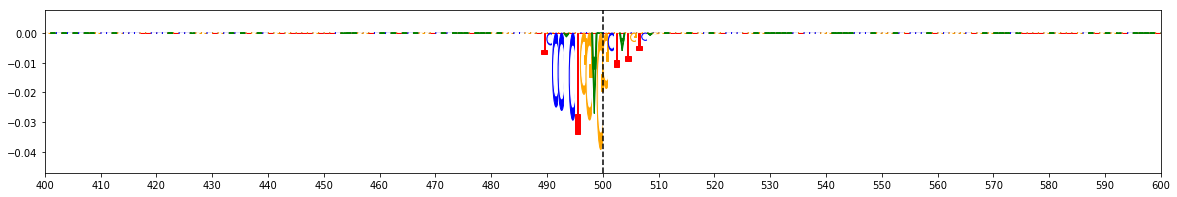


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
150  chr17   45896863   45896864   rs62056782      T         C           C   
169  chr17   45947293   45947294   rs62062786      G         C           G   
89   chr17   45442197   45442198   rs34887474      C         A           C   
420   chr8   22599691   22599692     rs755934      T         G           T   
5     chr1  232508907  232508908   rs12073680      G         A           A   
415   chr7  100217743  100217744    rs1727139      C         T           C   
167  chr17   45947185   45947186   rs62062784      G         C           C   
159  chr17   45940574   45940575   rs62061732      T         G           G   
224  chr19   44723890   44723891  rs150820726      T         A           A   
414   chr7  100217623  100217624    rs1727138      T         C           T   
295   chr2  127084806  127084807   rs11691237      T         C           C   
183  chr17   46066884   46066885   rs62060799      T         G           G   
361   chr4   89709649   89709650     rs356176      G         C           G   
365   chr4   89722705   89722706    rs3857052      G         A           G   
4     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
289   chr2  101762281  101762282    rs2068397      C         A           C   
193  chr17   46771150   46771151     rs199523      C         A           C   
118  chr17   45839142   45839143   rs10445333      G         A           A   
310   chr2  134719288  134719289   rs62171396      T         C           C   
332   chr3   52339932   52339933  rs149814394      G         A           G   
152  chr17   45897109   45897110   rs80346216      T         G           G   
436   chr9   17578708   17578709    rs3758216      G         C           G   
352   chr4     987143     987144   rs10902762      G         A           G   
211  chr18   51198353   51198354    rs3819118      T         C           C   
287   chr2  101761911  101761912   rs12476714      G         A           A   
31   chr11   65834088   65834089   rs17854357      C         G           G   
184  chr17   46100970   46100971   rs17660488      T         C           T   
166  chr17   45942947   45942948   rs62062772      T         C           C   
76   chr17    4877499    4877500   rs72835045      A         G           G   
187  chr17   46122303   46122304   rs62061855      G         A           G   
..     ...        ...        ...          ...    ...       ...         ...   
29   chr11   47426945   47426946   rs11600581      T         C           T   
385   chr4   89836353   89836354    rs1372520      T         C           T   
3     chr1  207565781  207565782    rs3886100      A         G           A   
116  chr17   45827243   45827244   rs62057154      T         C           C   
146  chr17   45896041   45896042  rs113347741      T         C           C   
349   chr4     973656     973657   rs13137144      G         A           G   
127  chr17   45849625   45849626   rs56269136      T         C           C   
228  chr19   44784591   44784592    rs2927448      T         G           G   
227  chr19   44758447   44758448   rs34967149      T         C           C   
11   chr10   15515115   15515116     rs878321      G         A           G   
88   chr17   44220262   44220263  rs113844752      C         A           C   
22   chr11   47255123   47255124   rs11039149      A         G           A   
379   chr4   89829957   89829958    rs2583980      T         G           T   
148  chr17   45896131   45896132    rs4792891      T         G           T   
188  chr17   46192597   46192598   rs11079733      T         A           T   
137  chr17   45894114   45894115   rs80233201      T         C           T   
231  chr19   44808778   44808779    rs2967671      G         C           C   
174  chr17   46002200   46002201   rs17573447      T         C           C   
393   chr5  103010211  103010212    rs1826673      G         A           G   
360   chr4   89709523   89709

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 150   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.4306   ||  Center / 200bp: 0.7088
Effect Sequence: CTCGCCCTCTTGTGATGAAC


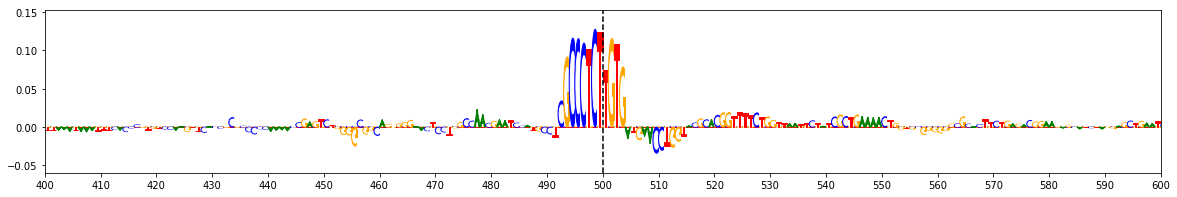

Noneffect Allele: C   ||  Explain Score: 0.5177   ||  Center / 200bp: 0.4685
Noneffect Sequence: CTCGCCCTCCTGTGATGAAC


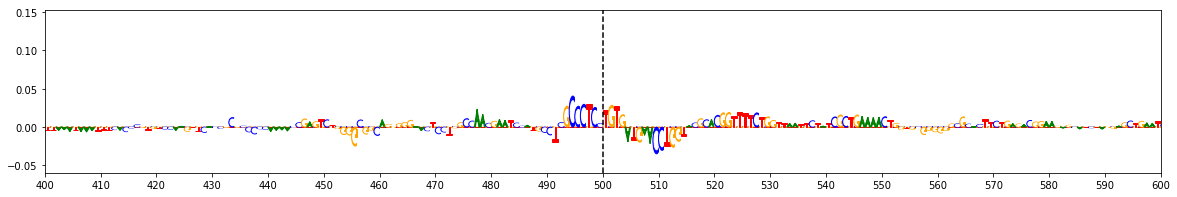

Allele Ratio : 2.7634   ||   Allele Difference : 0.9349  ||  ISM Score : 1.4602  ||  deltaSVM Score : 8.3614


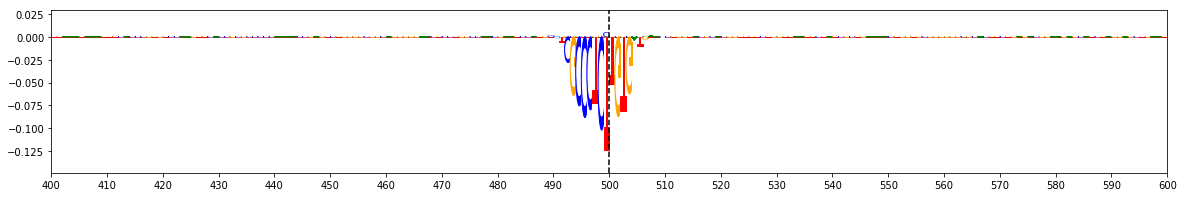


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 169   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  4.53E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7968   ||  Center / 200bp: 0.4932
Effect Sequence: TGGGGACCAGCTGCCACAGA


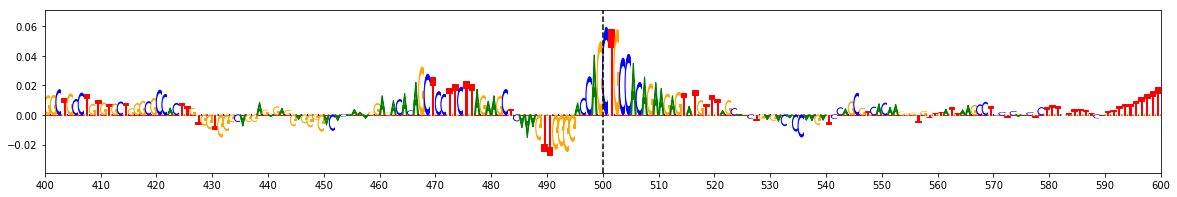

Noneffect Allele: C   ||  Explain Score: 0.3193   ||  Center / 200bp: 0.2806
Noneffect Sequence: TGGGGACCACCTGCCACAGA


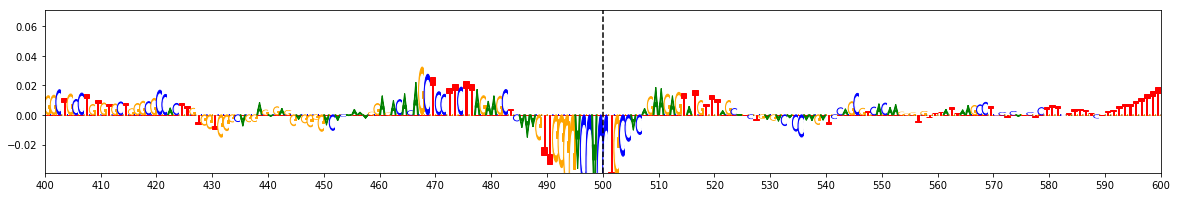

Allele Ratio : 2.4956   ||   Allele Difference : 1.1359  ||  ISM Score : 1.8511  ||  deltaSVM Score : 10.5726


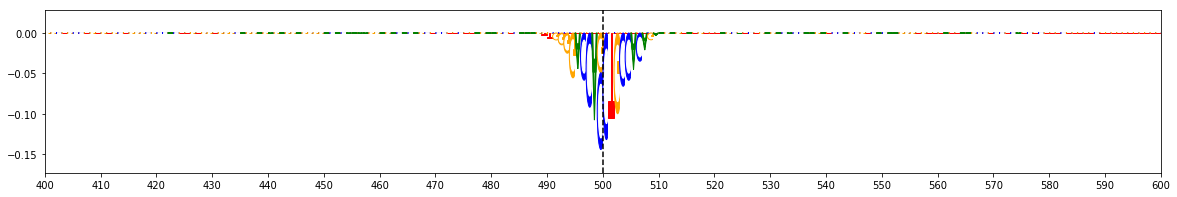


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34887474   ||    chr17 : 45442197 - 45442198   ||    Locus: 89   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.43E-21

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.4479   ||  Center / 200bp: 0.8054
Effect Sequence: AGAACCCTGCCAGGCAGCTG


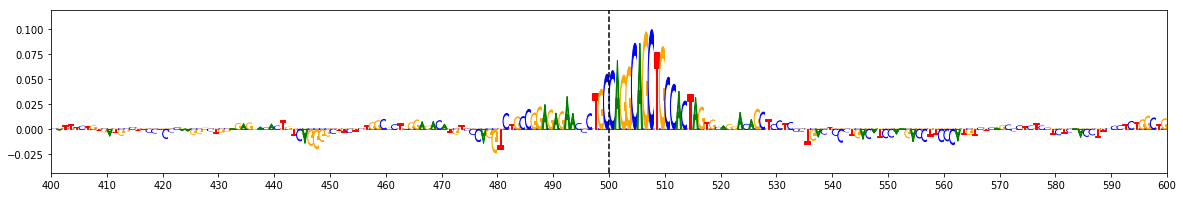

Noneffect Allele: A   ||  Explain Score: 0.9944   ||  Center / 200bp: 0.7396
Noneffect Sequence: AGAACCCTGACAGGCAGCTG


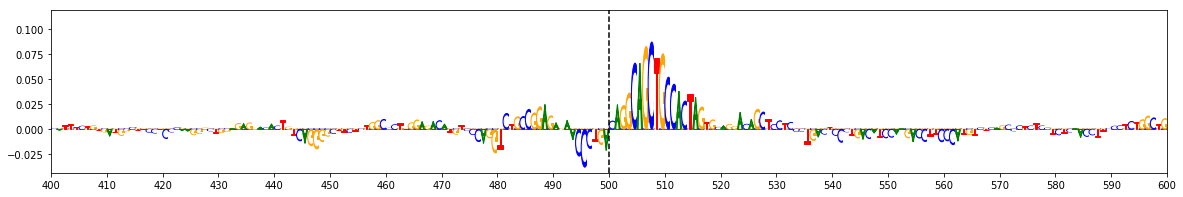

Allele Ratio : 1.4561   ||   Allele Difference : 0.5931  ||  ISM Score : 0.9211  ||  deltaSVM Score : 5.3879


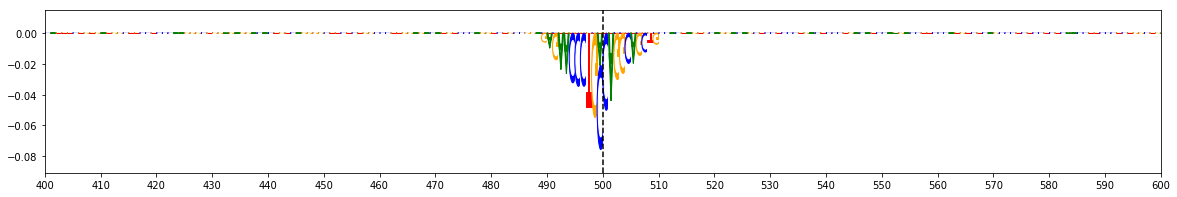


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 420   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.909   ||  Center / 200bp: 0.5707
Effect Sequence: GCGGCTGCATTGGCCGGGGC


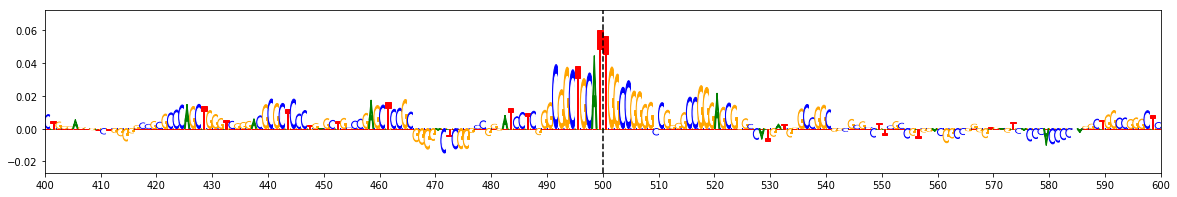

Noneffect Allele: G   ||  Explain Score: 0.531   ||  Center / 200bp: 0.4386
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


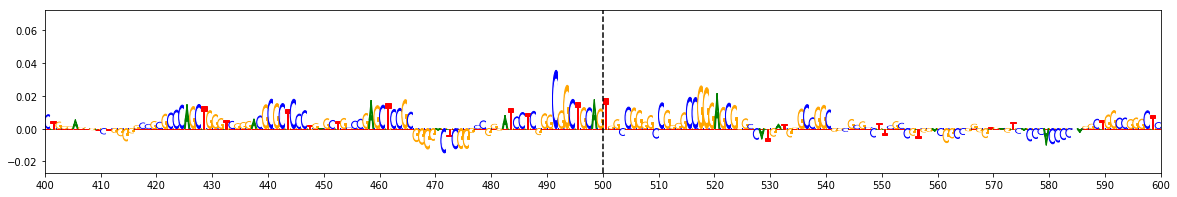

Allele Ratio : 1.7118   ||   Allele Difference : 0.384  ||  ISM Score : 0.6146  ||  deltaSVM Score : 3.8385


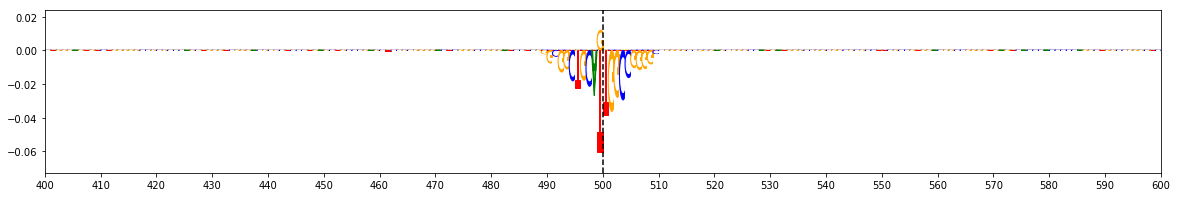


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12073680   ||    chr1 : 232508907 - 232508908   ||    Locus: 5   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.90E-03
Nalls_23andMe 		  3.90E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.1677   ||  Center / 200bp: 0.4633
Effect Sequence: CTGGCCAACGCGGCGAAACC


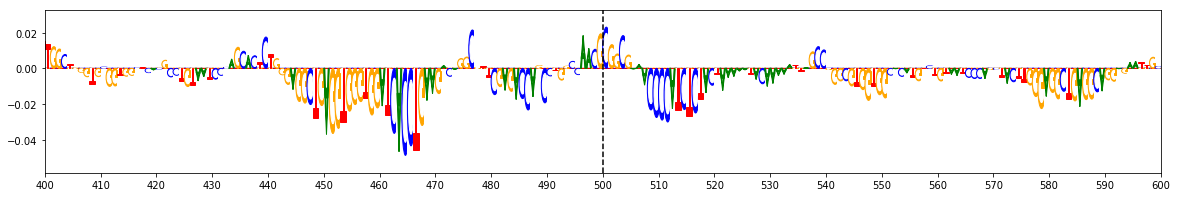

Noneffect Allele: A   ||  Explain Score: 0.0802   ||  Center / 200bp: 0.2926
Noneffect Sequence: CTGGCCAACACGGCGAAACC


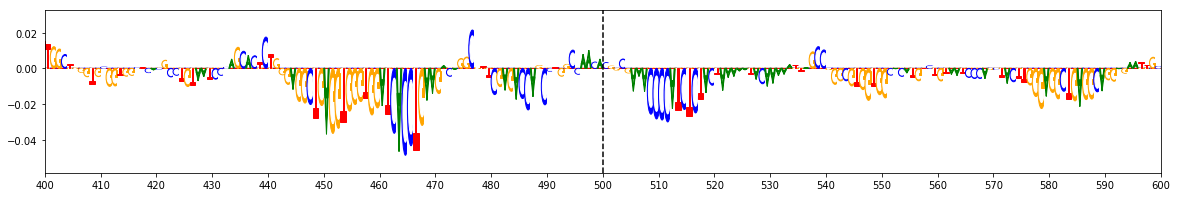

Allele Ratio : 2.0893   ||   Allele Difference : 0.1094  ||  ISM Score : 0.1746  ||  deltaSVM Score : 0.9841


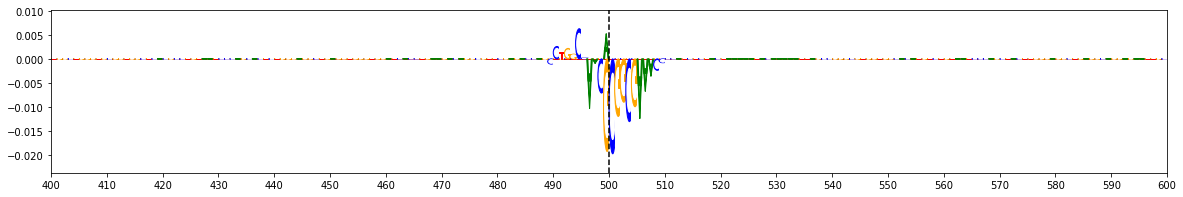


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1727139   ||    chr7 : 100217743 - 100217744   ||    Locus: 415   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.85E-10

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.8175   ||  Center / 200bp: 0.511
Effect Sequence: TAGCCGAGGCGGAGAGAGAG


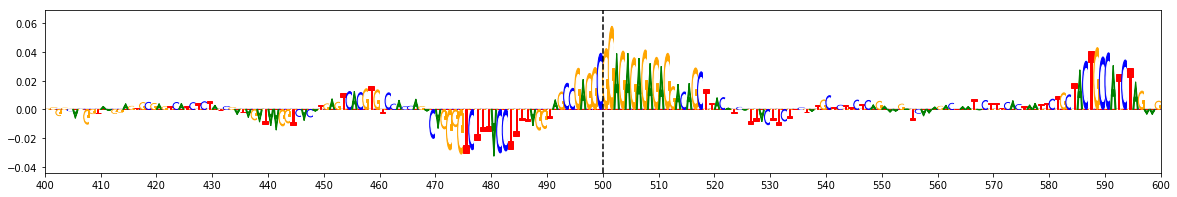

Noneffect Allele: T   ||  Explain Score: 0.4489   ||  Center / 200bp: 0.3648
Noneffect Sequence: TAGCCGAGGTGGAGAGAGAG


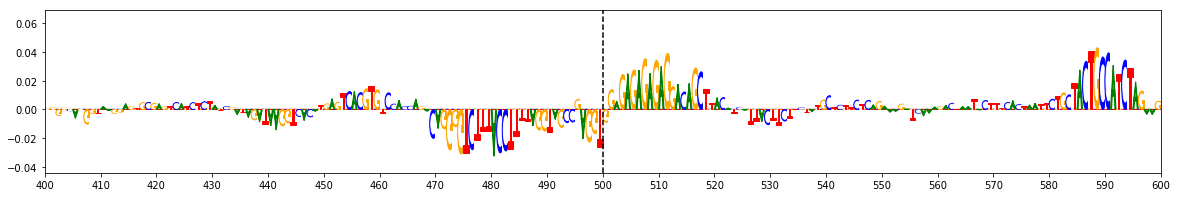

Allele Ratio : 1.821   ||   Allele Difference : 0.5117  ||  ISM Score : 0.797  ||  deltaSVM Score : 4.6536


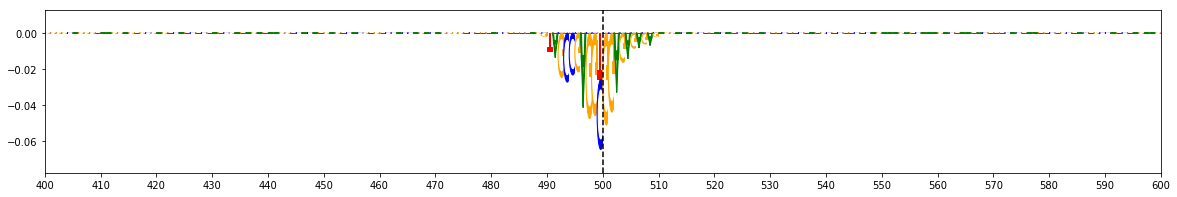


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062784   ||    chr17 : 45947185 - 45947186   ||    Locus: 167   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.3571   ||  Center / 200bp: 0.5939
Effect Sequence: TACTGAGCAGCTCCCAGTGG


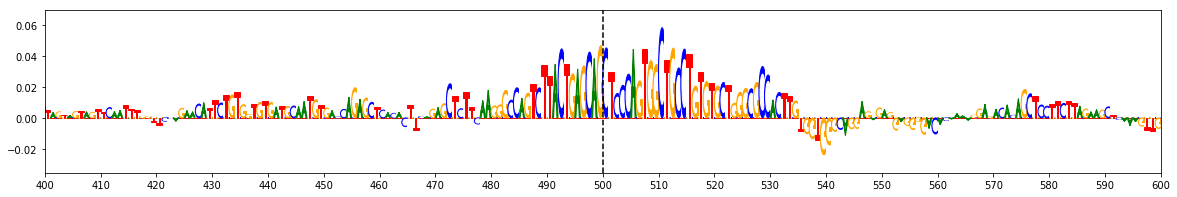

Noneffect Allele: C   ||  Explain Score: 0.9247   ||  Center / 200bp: 0.4987
Noneffect Sequence: TACTGAGCACCTCCCAGTGG


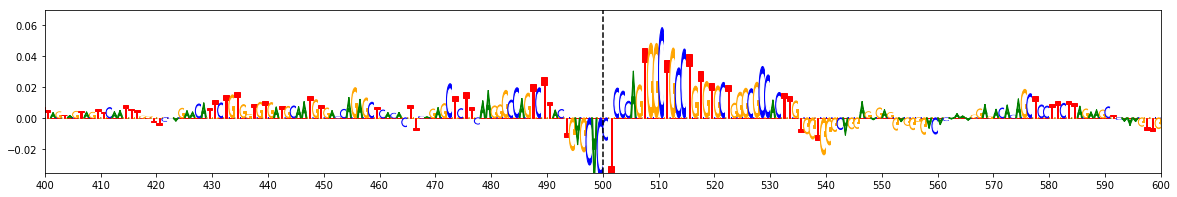

Allele Ratio : 1.4676   ||   Allele Difference : 0.6741  ||  ISM Score : 1.0553  ||  deltaSVM Score : 6.1463


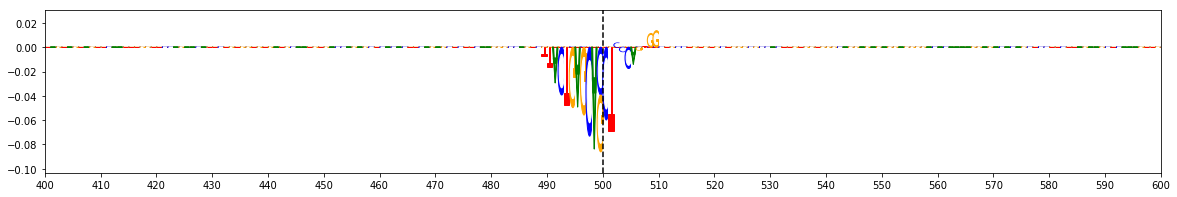


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62061732   ||    chr17 : 45940574 - 45940575   ||    Locus: 159   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.04E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.2954   ||  Center / 200bp: 0.2904
Effect Sequence: CCAGCCCAGTTAAGGAATAG


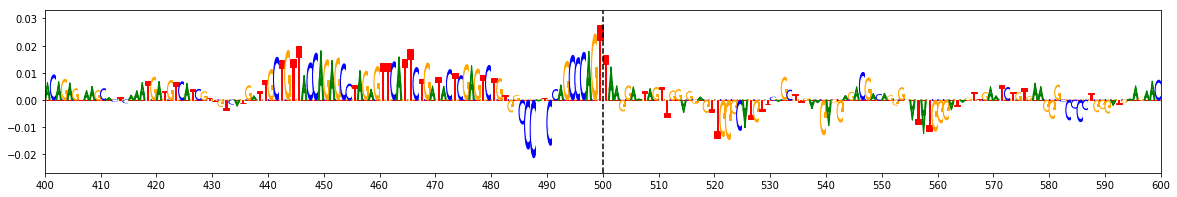

Noneffect Allele: G   ||  Explain Score: 0.0999   ||  Center / 200bp: 0.1216
Noneffect Sequence: CCAGCCCAGGTAAGGAATAG


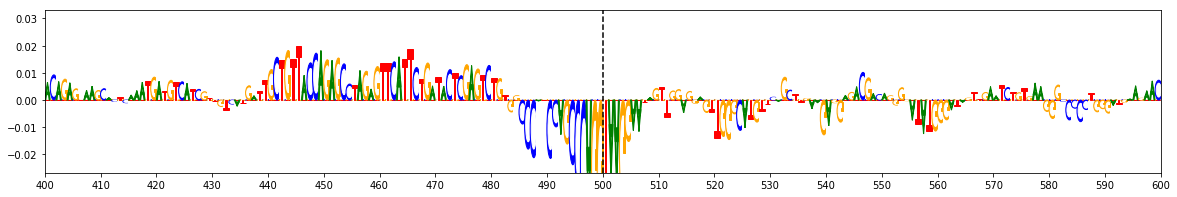

Allele Ratio : 2.9553   ||   Allele Difference : 0.7216  ||  ISM Score : 1.1276  ||  deltaSVM Score : 6.4882


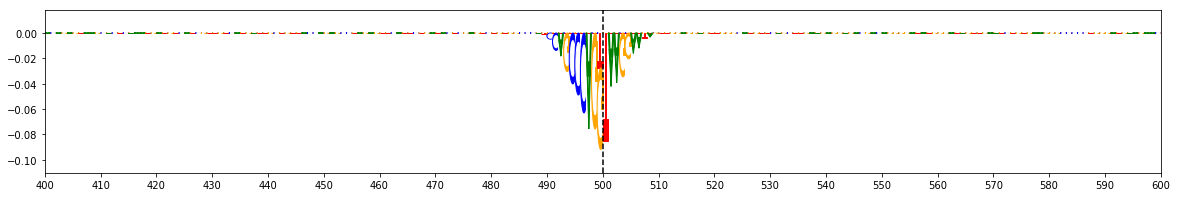


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs150820726   ||    chr19 : 44723890 - 44723891   ||    Locus: 224   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.02E-11

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.2264   ||  Center / 200bp: 0.6513
Effect Sequence: AGCTGCCACTTGCAGGGTGA


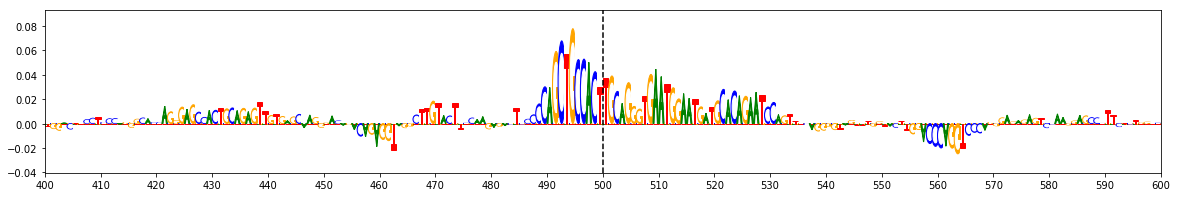

Noneffect Allele: A   ||  Explain Score: 0.9311   ||  Center / 200bp: 0.586
Noneffect Sequence: AGCTGCCACATGCAGGGTGA


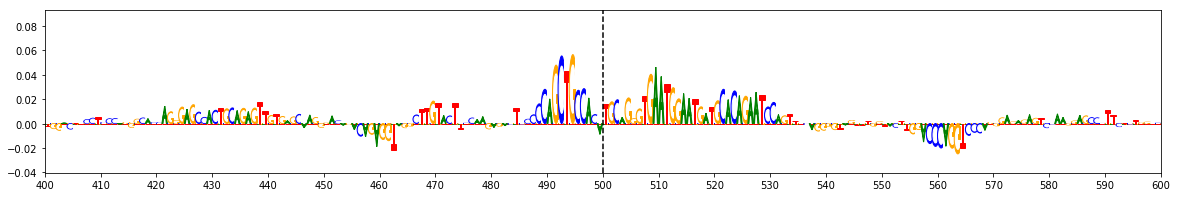

Allele Ratio : 1.3172   ||   Allele Difference : 0.3042  ||  ISM Score : 0.4784  ||  deltaSVM Score : 2.7615


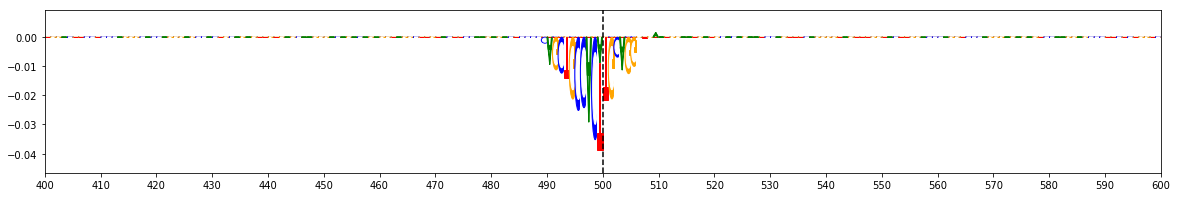


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1727138   ||    chr7 : 100217623 - 100217624   ||    Locus: 414   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  6.14E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8179   ||  Center / 200bp: 0.5833
Effect Sequence: GCGCTGCTATTTATGGTATT


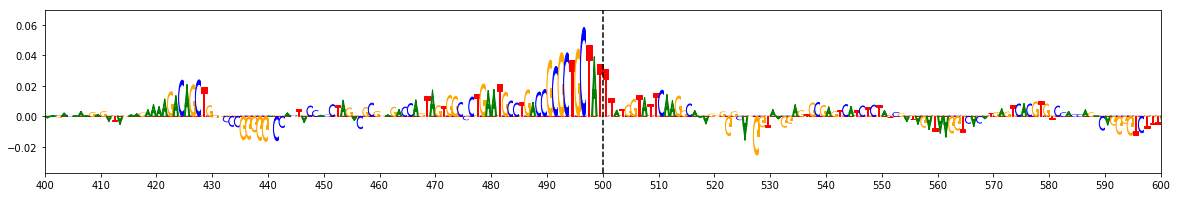

Noneffect Allele: C   ||  Explain Score: 0.5584   ||  Center / 200bp: 0.4886
Noneffect Sequence: GCGCTGCTACTTATGGTATT


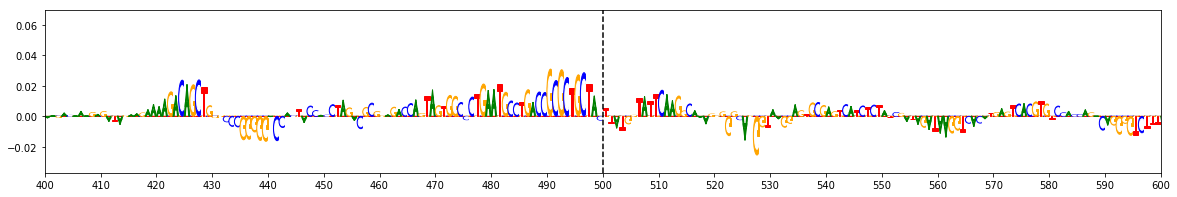

Allele Ratio : 1.4648   ||   Allele Difference : 0.2879  ||  ISM Score : 0.4511  ||  deltaSVM Score : 2.6037


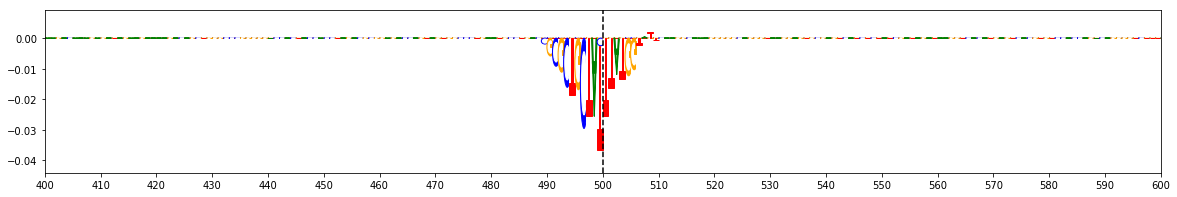


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11691237   ||    chr2 : 127084806 - 127084807   ||    Locus: 295   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.22E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.2579   ||  Center / 200bp: 0.7143
Effect Sequence: CTCTGAGCCTATTGCAGTGT


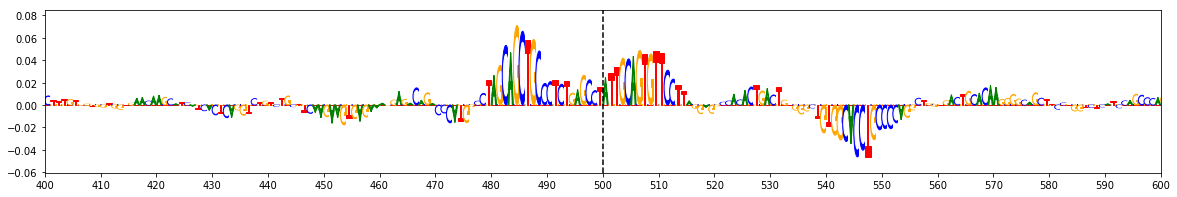

Noneffect Allele: C   ||  Explain Score: 1.0869   ||  Center / 200bp: 0.6836
Noneffect Sequence: CTCTGAGCCCATTGCAGTGT


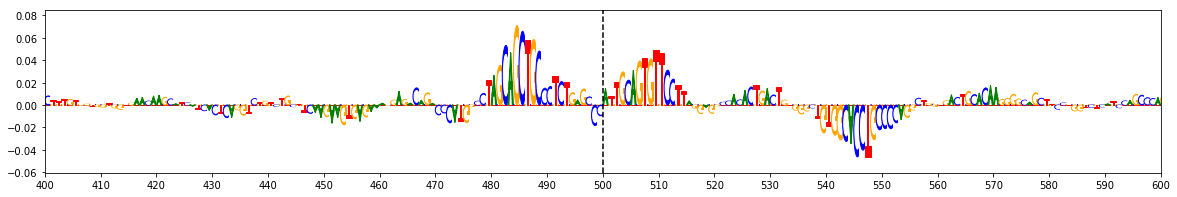

Allele Ratio : 1.1573   ||   Allele Difference : 0.1991  ||  ISM Score : 0.3125  ||  deltaSVM Score : 1.7735


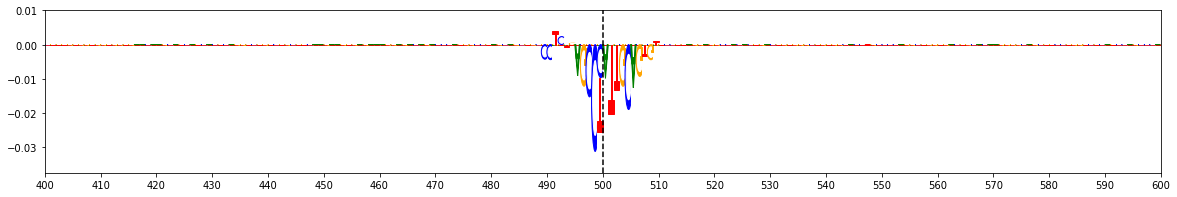


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62060799   ||    chr17 : 46066884 - 46066885   ||    Locus: 183   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.66E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5416   ||  Center / 200bp: 0.3832
Effect Sequence: CAGAAGCAGTTCTCCTCTTG


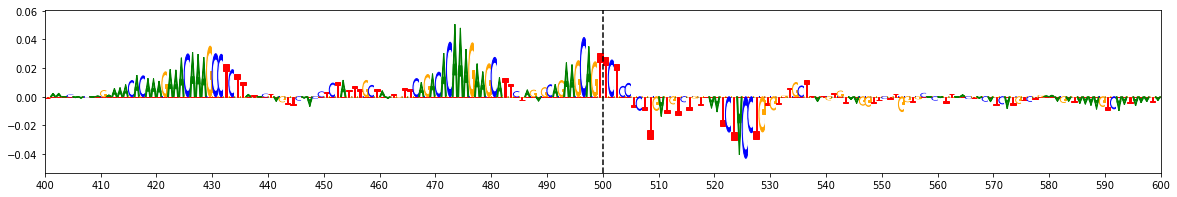

Noneffect Allele: G   ||  Explain Score: 0.2512   ||  Center / 200bp: 0.223
Noneffect Sequence: CAGAAGCAGGTCTCCTCTTG


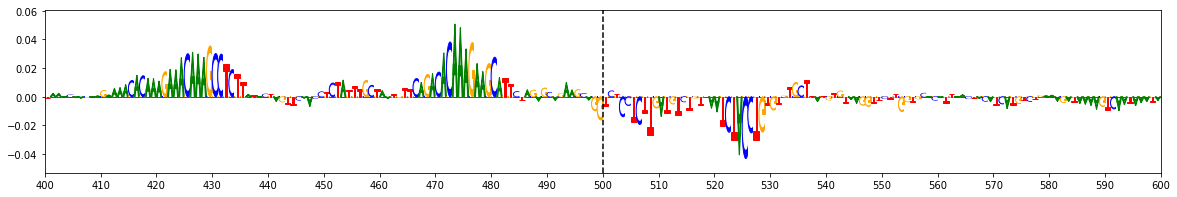

Allele Ratio : 2.156   ||   Allele Difference : 0.3669  ||  ISM Score : 0.5858  ||  deltaSVM Score : 3.3655


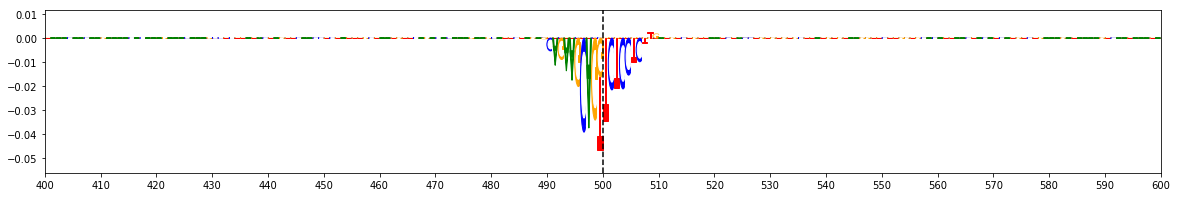


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs356176   ||    chr4 : 89709649 - 89709650   ||    Locus: 361   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.13E-12
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.9757   ||  Center / 200bp: 0.6829
Effect Sequence: GGACTCAGTGTCTTCTTTGC


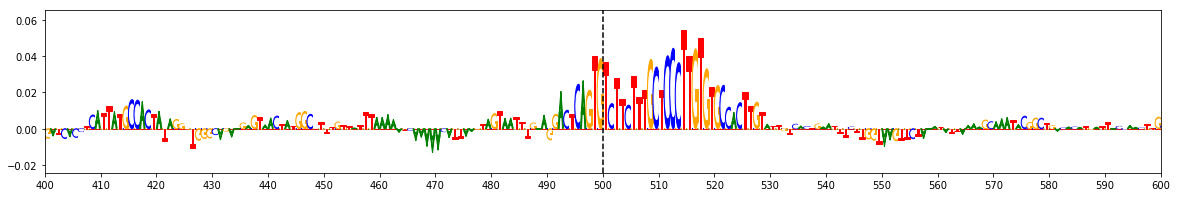

Noneffect Allele: C   ||  Explain Score: 0.8547   ||  Center / 200bp: 0.6536
Noneffect Sequence: GGACTCAGTCTCTTCTTTGC


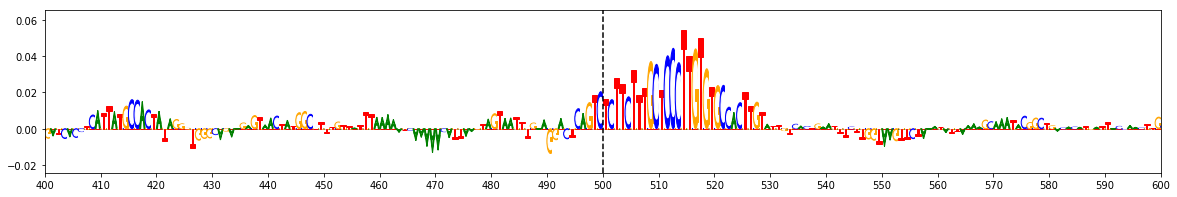

Allele Ratio : 1.1416   ||   Allele Difference : 0.1448  ||  ISM Score : 0.2272  ||  deltaSVM Score : 1.3396


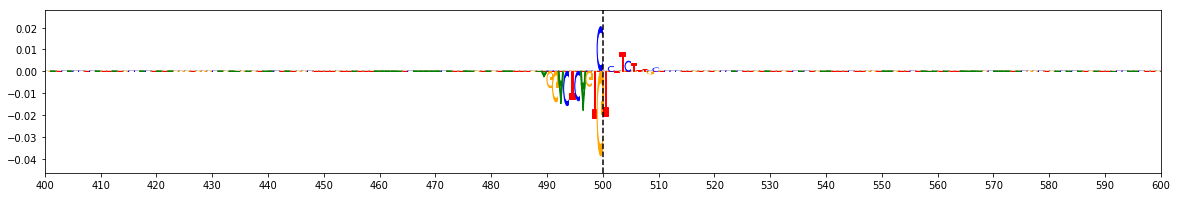


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3857052   ||    chr4 : 89722705 - 89722706   ||    Locus: 365   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.31E-18

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.3506   ||  Center / 200bp: 0.6361
Effect Sequence: GACTGTGGTGCTGTAATGTT


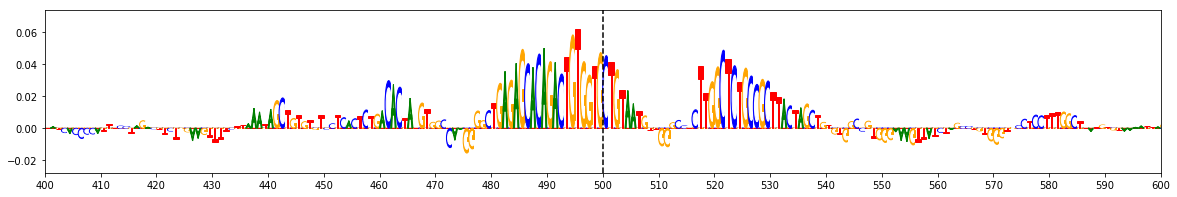

Noneffect Allele: A   ||  Explain Score: 1.1194   ||  Center / 200bp: 0.5916
Noneffect Sequence: GACTGTGGTACTGTAATGTT


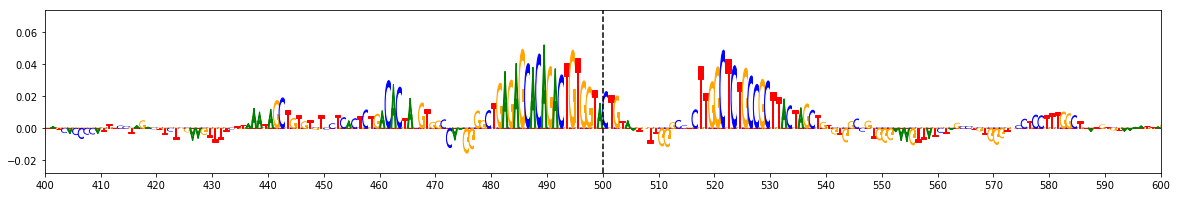

Allele Ratio : 1.2065   ||   Allele Difference : 0.2448  ||  ISM Score : 0.3838  ||  deltaSVM Score : 2.2222


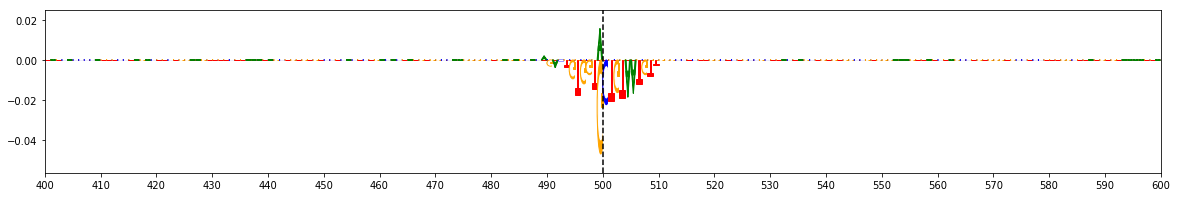


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147889095   ||    chr1 : 226737182 - 226737183   ||    Locus: 4   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.77E-05
Nalls_23andMe 		  1.77E-05

Coloc:  False

Effect Allele: I   ||  Explain Score: 1.117   ||  Center / 200bp: 0.6116
Effect Sequence: ACTGCCGCTGCCACTGCCGC


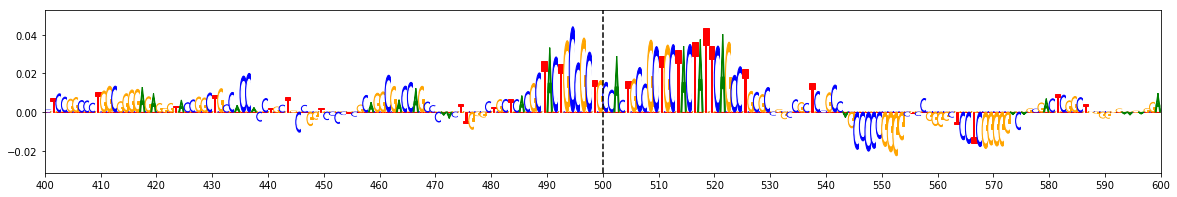

Noneffect Allele: D   ||  Explain Score: 0.8912   ||  Center / 200bp: 0.4993
Noneffect Sequence: ACTGCCGCTGCTGCCGCTGC


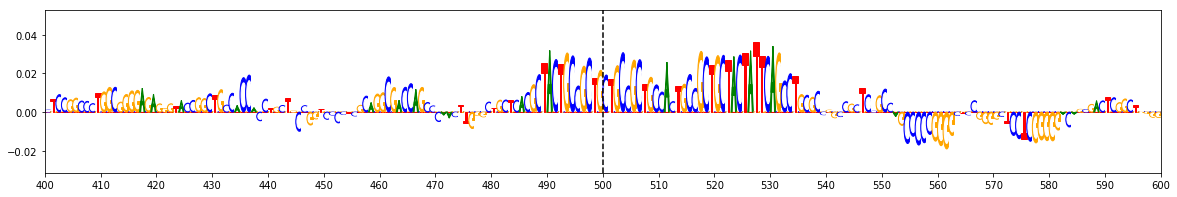

Allele Ratio : 1.2534   ||   Allele Difference : 0.225  ||  ISM Score : 0.3593  ||  deltaSVM Score : 1.905


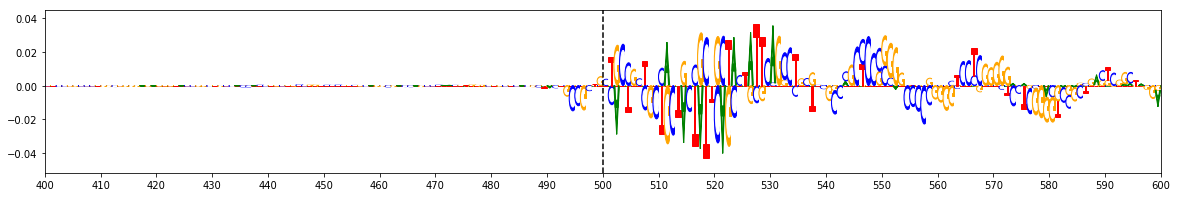


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2068397   ||    chr2 : 101762281 - 101762282   ||    Locus: 289   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.14E-03
Nalls_23andMe 		  1.14E-03

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.5141   ||  Center / 200bp: 0.5074
Effect Sequence: GGCAAATTGCCACACCTAGG


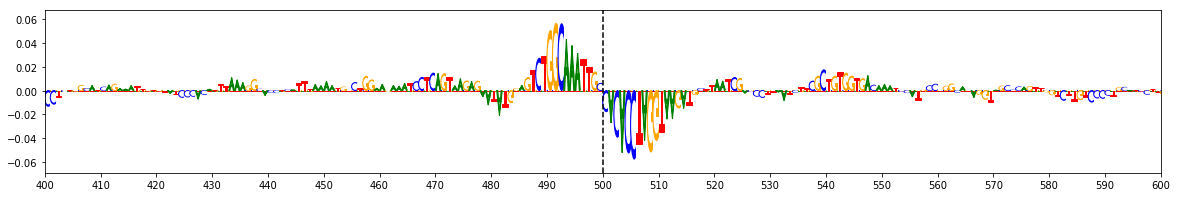

Noneffect Allele: A   ||  Explain Score: 0.3449   ||  Center / 200bp: 0.407
Noneffect Sequence: GGCAAATTGACACACCTAGG


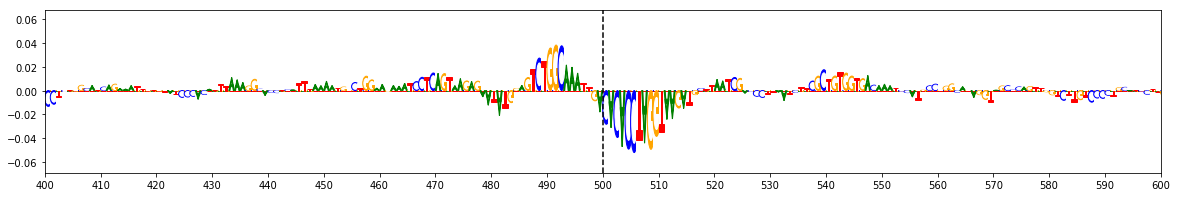

Allele Ratio : 1.4908   ||   Allele Difference : 0.1918  ||  ISM Score : 0.302  ||  deltaSVM Score : 1.6543


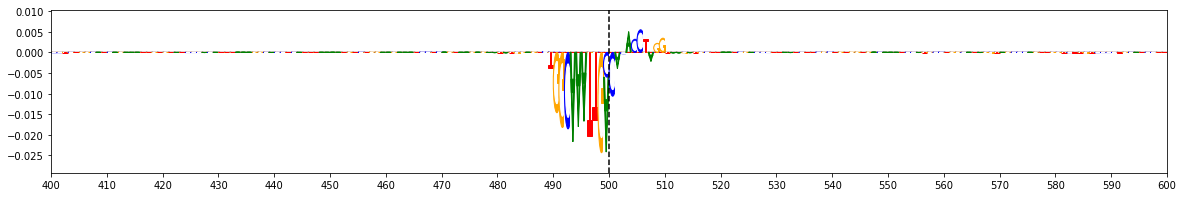


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 193   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 1.0094   ||  Center / 200bp: 0.3688
Effect Sequence: GCCCTCCTGCGCCACCTACA


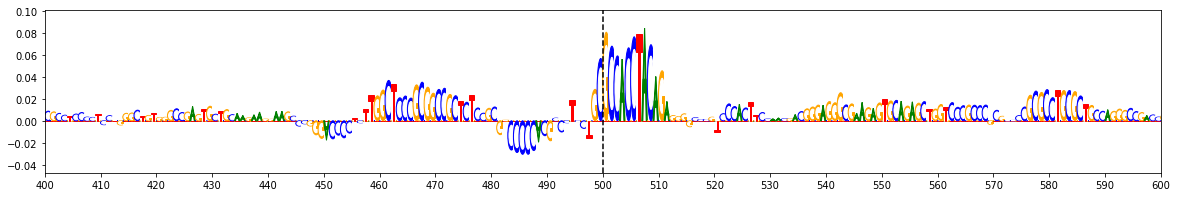

Noneffect Allele: A   ||  Explain Score: 0.4932   ||  Center / 200bp: 0.2217
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


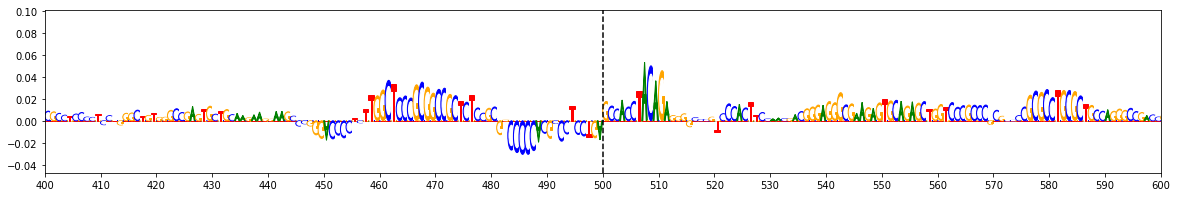

Allele Ratio : 2.0467   ||   Allele Difference : 0.5842  ||  ISM Score : 0.9275  ||  deltaSVM Score : 5.3674


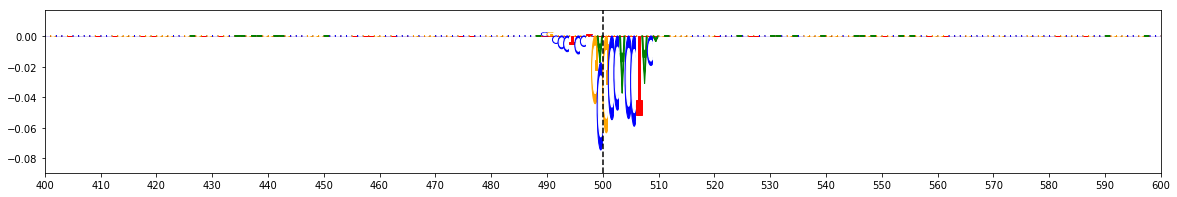


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10445333   ||    chr17 : 45839142 - 45839143   ||    Locus: 118   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  8.95E-23

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.154   ||  Center / 200bp: 0.5408
Effect Sequence: TGACTTCCAGCTCAGCTGCC


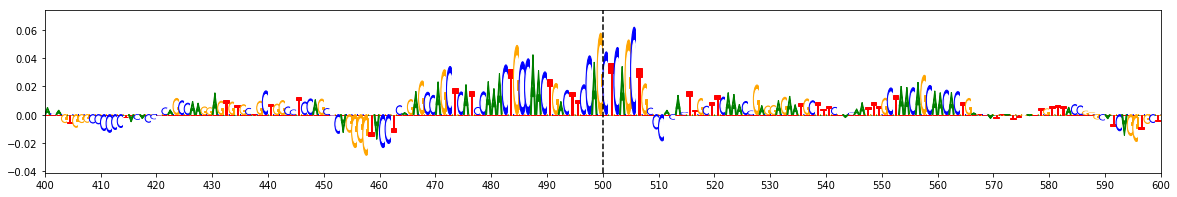

Noneffect Allele: A   ||  Explain Score: 0.8358   ||  Center / 200bp: 0.4596
Noneffect Sequence: TGACTTCCAACTCAGCTGCC


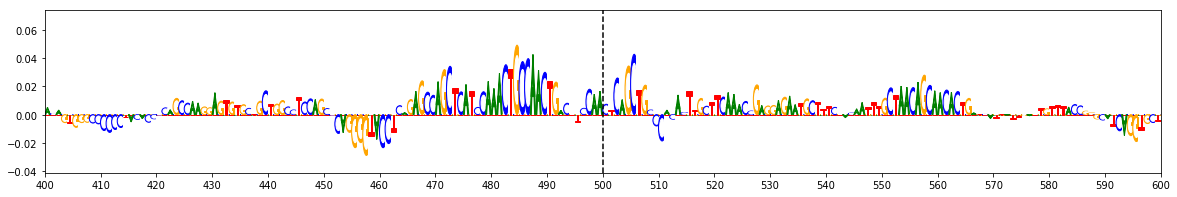

Allele Ratio : 1.3807   ||   Allele Difference : 0.322  ||  ISM Score : 0.5052  ||  deltaSVM Score : 2.7887


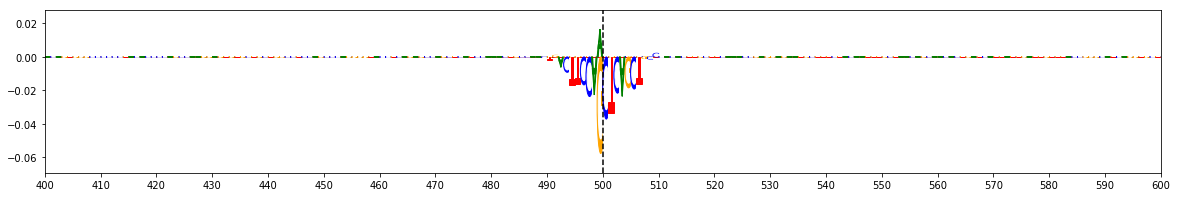


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 310   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.1303   ||  Center / 200bp: 0.5943
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


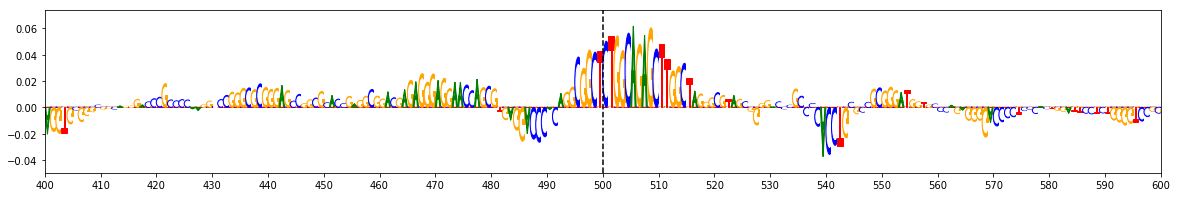

Noneffect Allele: C   ||  Explain Score: 0.9516   ||  Center / 200bp: 0.5509
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


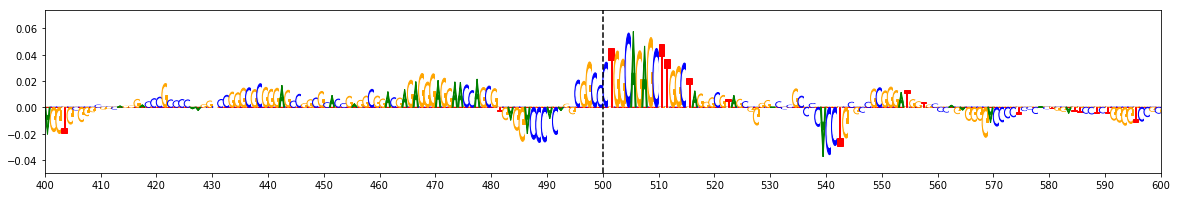

Allele Ratio : 1.1878   ||   Allele Difference : 0.2046  ||  ISM Score : 0.3195  ||  deltaSVM Score : 1.8913


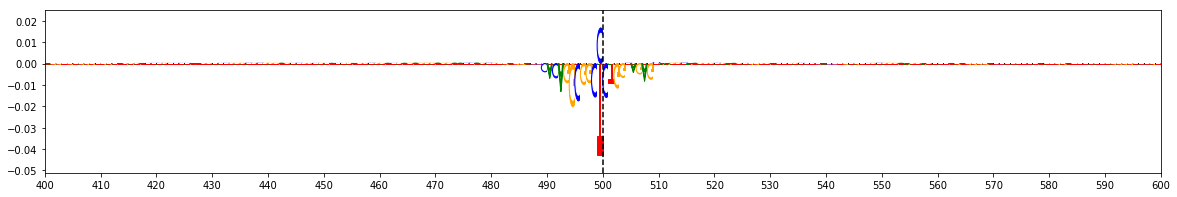


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs149814394   ||    chr3 : 52339932 - 52339933   ||    Locus: 332   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.38E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5266   ||  Center / 200bp: 0.4214
Effect Sequence: TATCCTCCAGTCTACAAATG


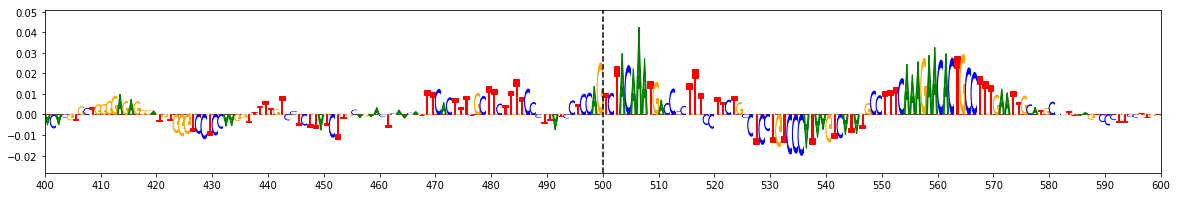

Noneffect Allele: A   ||  Explain Score: 0.3186   ||  Center / 200bp: 0.3059
Noneffect Sequence: TATCCTCCAATCTACAAATG


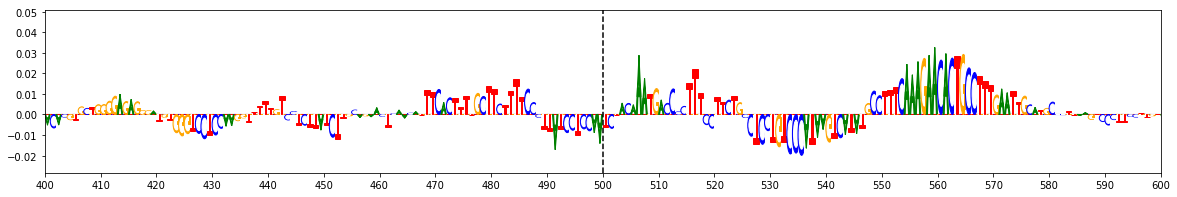

Allele Ratio : 1.6529   ||   Allele Difference : 0.3082  ||  ISM Score : 0.5119  ||  deltaSVM Score : 2.9526


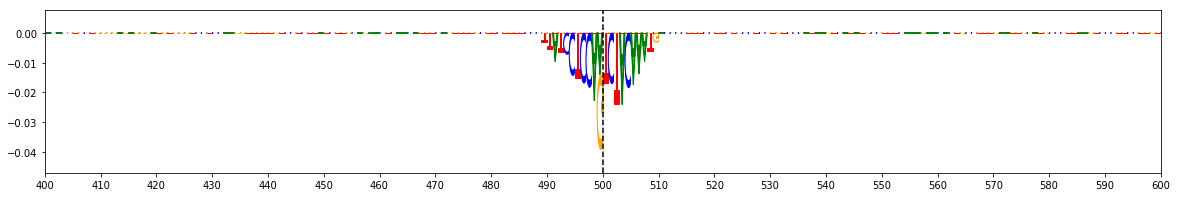


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()